# Desarrollo de modelos

Este notebook se utiliza para el desarrollo de modelos de clasificación para el problema seleccionado. 
El procedimiento está organizado en las siguientes secciones:

1. Carga del dataset
2. Análisis Exploratorio de Datos
3. Preprocesamiento
4. Ingeniería de Features
5. Desarrollo y Entrenamiento de Modelos

## Descripción del problema

Dado un [dataset de operaciones con tarjetas de crédito (fuente:Kaggle)](https://www.kaggle.com/mlg-ulb/creditcardfraud) que tiene etiquetadas operaciones identificadas como fraude o no fraude, interesa elaborar un modelo que permita clasificar automáticamente nuevas operaciones.

El dataset contiene:
- **Información temporal**: Los segundos transcurridos desde la primer operación registrada en el dataset. El tiempo inicial real es desconocido. Dado que este campo no se utiliza, se asignó una fecha arbitraria sólo con la finalidad de visualizar los datos en herramientas que soportan la búsqueda por indexado temporal (ejemplos: Grafana y Kibana).
- **Features v1-v28**: de acuerdo a la descripción del dataset, características resultantes de haber aplicado PCA para proteger la identidad de los usuarios y capturar aquellas de mayor relevancia para el problema.
- **Monto de la operación**
- **Resultado de la clasificación**: 0=No fraude, 1=Fraude.


### Alcance y Limitaciones

- Si bien está disponible la información temporal, los modelos estudiados en este trabajo tratarán el problema como si se tratara de eventos aislados. Están fuera del alcance RNNs, u otros algoritmos que utilicen información temporal.
- Se asume que las nuevas operaciones han pasado por el mismo proceso de PCA que el dataset original. Como este proceso es desconocido en este ejericicio, se particionará el dataset en un lote de datos para desarrollo del modelo (entrenamiento o entrenamiento/validación dependiendo del caso) y otro lote para evaluación.

## Procedimiento

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import joblib

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

TMP_PATH = "./tmp/" # Path temporal usado para imágenes generadas, archivos intermedios, etc.
MODELS_PATH = "/models/"

### 1. Carga del dataset

Se puede cargar el dataset desde el archivo CSV original o desde ElasticSearch. Para este trabajo se propone el segundo método.

#### Opción 1) De archivo CSV.

In [2]:
DATASET_FILENAME_PATH = "/data/credit_fraud/creditcard.csv"

def load_credit_fraud_from_csv(path=DATASET_FILENAME_PATH):
    col_names = [ "time" ]
    col_names.extend(["v{}".format(x) for x in range(1,28)])
    col_names.append( "amount" )
    col_names.append( "class" )
    return pd.read_csv(DATASET_FILENAME_PATH,skiprows=1,index_col=0, names=col_names)

#### Opción 2) De ElasticSearch.

In [3]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search

ELASTICSEARCH_HOST = 'elasticsearch'
ELASTICSEARCH_PORT = 9200
ELASTICSEARCH_DATASET_INDEX = 'creditfraud-1'

def load_credit_fraud_from_elasticsearch(host=ELASTICSEARCH_HOST,port=ELASTICSEARCH_PORT, 
                                         index=ELASTICSEARCH_DATASET_INDEX):
    es = Elasticsearch(f"http://{ELASTICSEARCH_HOST}:{ELASTICSEARCH_PORT}/")
    s = Search(using=es, index=index)
    return pd.DataFrame([hit.to_dict() for hit in s.scan()]).astype(float)

In [4]:
#df = load_credit_fraud_from_csv()
df = load_credit_fraud_from_elasticsearch()

### 2. Análisis Exploratorio de Datos

A continuación se hará una exploración inicial del dataset.

In [5]:
df.head()

time        v1        v2        v3        v4        v5        v6  \
0  1.602720e+09 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1  1.602720e+09  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2  1.602720e+09 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3  1.602720e+09 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4  1.602720e+09 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   

         v7        v8        v9  ...       v22       v23       v24       v25  \
0  0.239599  0.098698  0.363787  ...  0.277838 -0.110474  0.066928  0.128539   
1 -0.078803  0.085102 -0.255425  ... -0.638672  0.101288 -0.339846  0.167170   
2  0.791461  0.247676 -1.514654  ...  0.771679  0.909412 -0.689281 -0.327642   
3  0.237609  0.377436 -1.387024  ...  0.005274 -0.190321 -1.175575  0.647376   
4  0.592941 -0.270533  0.817739  ...  0.798278 -0.137458  0.141267 -0.206010   

        v26       v27       v28  amount  class  row_id  
0 -0.189115  0.133558 -0.021053  149.62    0.0     0.0  
1  0.125895 -0.008983  0.014724    2.69    0.0     1.0  
2 -0.139097 -0.055353 -0.059752  378.66    0.0     2.0  
3 -0.221929  0.062723  0.061458  123.50    0.0     3.0  
4  0.502292  0.219422  0.215153   69.99    0.0     4.0  

[5 rows x 32 columns]

Vista de tipos de datos de columnas (nota: los campos de interés ya han sido convertidos a Float previamente).

In [6]:
df.dtypes

time      float64
v1        float64
v2        float64
v3        float64
v4        float64
v5        float64
v6        float64
v7        float64
v8        float64
v9        float64
v10       float64
v11       float64
v12       float64
v13       float64
v14       float64
v15       float64
v16       float64
v17       float64
v18       float64
v19       float64
v20       float64
v21       float64
v22       float64
v23       float64
v24       float64
v25       float64
v26       float64
v27       float64
v28       float64
amount    float64
class     float64
row_id    float64
dtype: object

Estadísticas generales.

In [7]:
df.describe()

time            v1            v2            v3            v4  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.602815e+09  2.923228e-15  2.941874e-16 -7.913248e-15  1.894555e-15   
std    4.748815e+04  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min    1.602720e+09 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%    1.602774e+09 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%    1.602805e+09  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    1.602859e+09  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    1.602893e+09  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 v5            v6            v7            v8            v9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.829743e-16  1.470984e-15 -1.045995e-15 -2.445951e-16 -1.869256e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

       ...           v22           v23           v24           v25  \
count  ...  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   ... -4.302640e-16  6.094655e-17  4.444939e-15  1.606285e-15   
std    ...  7.257016e-01  6.244603e-01  6.056471e-01  5.212781e-01   
min    ... -1.093314e+01 -4.480774e+01 -2.836627e+00 -1.029540e+01   
25%    ... -5.423504e-01 -1.618463e-01 -3.545861e-01 -3.171451e-01   
50%    ...  6.781943e-03 -1.119293e-02  4.097606e-02  1.659350e-02   
75%    ...  5.285536e-01  1.476421e-01  4.395266e-01  3.507156e-01   
max    ...  1.050309e+01  2.252841e+01  4.584549e+00  7.519589e+00   

                v26           v27           v28         amount          class  \
count  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000  284807.000000   
mean   1.737425e-15 -3.925610e-16 -1.152161e-16      88.349619       0.001727   
std    4.822270e-01  4.036325e-01  3.300833e-01     250.120109       0.041527   
min   -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000       0.000000   
25%   -3.269839e-01 -7.083953e-02 -5.295979e-02       5.600000       0.000000   
50%   -5.213911e-02  1.342146e-03  1.124383e-02      22.000000       0.000000   
75%    2.409522e-01  9.104512e-02  7.827995e-02      77.165000       0.000000   
max    3.517346e+00  3.161220e+01  3.384781e+01   25691.160000       1.000000   

              row_id  
count  284807.000000  
mean   142403.000000  
std     82216.843396  
min         0.000000  
25%     71201.500000  
50%    142403.000000  
75%    213604.500000  
max    284806.000000  

[8 rows x 32 columns]

Distribución de clases. 

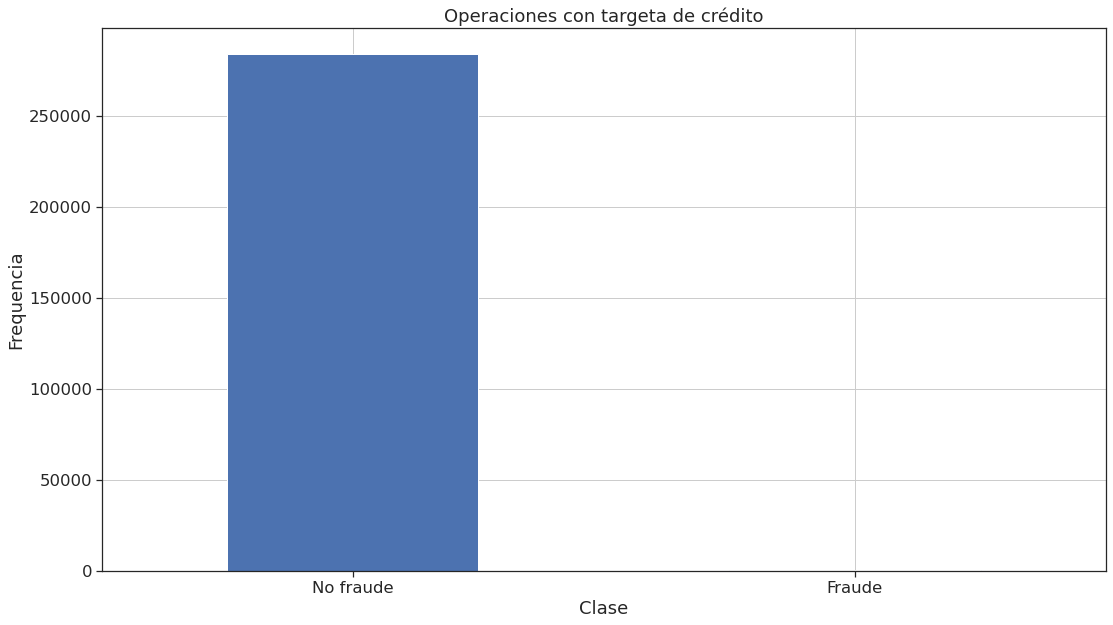

In [8]:
count_classes = pd.value_counts(df['class'], sort = True)
plt.figure(figsize=(18,10))
count_classes.plot(kind = 'bar', rot=0)
plt.title("Operaciones con targeta de crédito")
plt.xticks(range(2), ["No fraude", "Fraude"])
plt.grid(which="Both")
plt.xlabel("Clase")
plt.ylabel("Frequencia")
plt.show()

Lo primero que se observa es que el dataset está fuertemente desbalanceado. Esto representa un problema que se tratará en la etapa siguiente de preprocesamiento.
Se estudiará también la distribución por clases en el tiempo.

*Nota*: en el gráfico a continuación el eje vertical está en escala logarítmica.

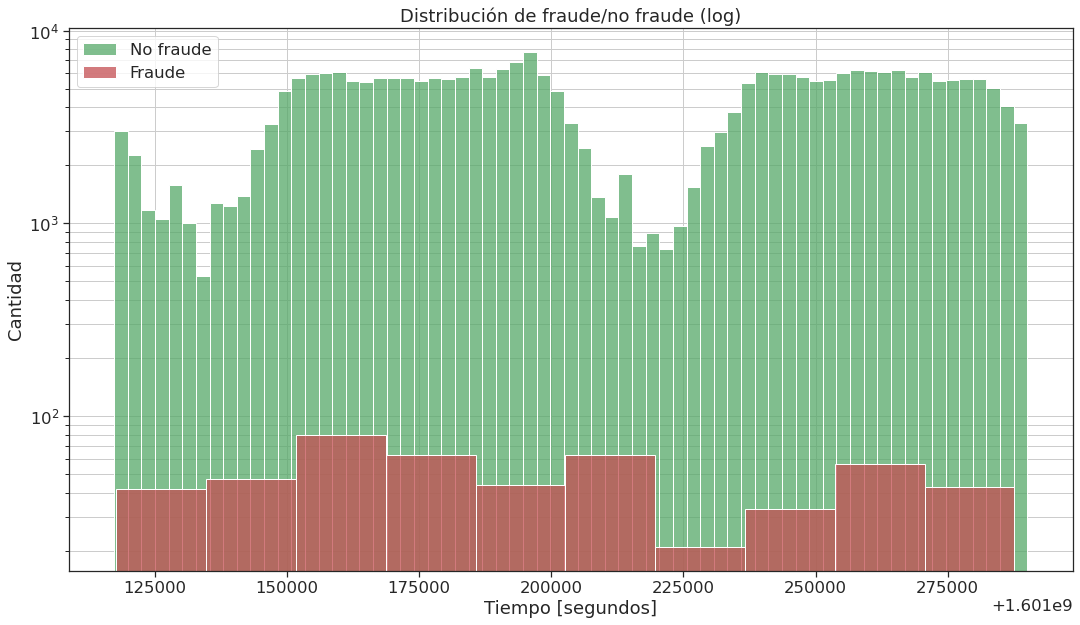

In [9]:
def plot_class_distribution_in_time(df, title,log=False):
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(18,10))
    ax.set_title(title)
    sns.histplot(df[df['class']==0]['time']-df.time.min()/1000, color='g', label='No fraude',ax=ax) 
    sns.histplot(df[df['class']==1]['time']-df.time.min()/1000, color='r', label='Fraude',ax=ax) 
    ax.grid(which="Both")
    if log:
        ax.set_yscale('log')
    ax.legend(["No fraude","Fraude"])
    plt.xlabel("Tiempo [segundos]")
    plt.ylabel("Cantidad")
    
plot_class_distribution_in_time(df,title='Distribución de fraude/no fraude (log)',log=True)

### 2. Preprocesamiento de dataset

#### 2.1 Manejo de datos inválidos

Este dataset, al igual que muchos descargados de Kaggle, ya fue previamente procesado y no contiene filas con NaNs.

In [10]:
ds_with_nans = df.loc[df.isna().sum(axis=1)>=1,:]
ds_without_nans = df.loc[df.isna().sum(axis=1)==0,:]
print("Filas con NaNs:{}".format(ds_with_nans.shape[0]))
print("Filas sin NaNs: {}".format(ds_without_nans.shape[0]))

Filas con NaNs:0
Filas sin NaNs: 284807


#### 2.2 Manejo de datos imbalanceados.

Como se observó en el análisis exploratorio inicial, los datos están fuertemente desbalanceados en favor de los casos no fraudulentos (esto es esperableen los problemas de detección de fallas/anomalías).
Aquí se pueden adoptar distintas estrategias:
1. **Upsampling**: aumentar la cantidad de muestras de la clase minoritaria (agregando muestras reales o artificiales).
2. **Downsampling**: reducir la cantidad de muestras de la clase mayoritaria.
3. **Seleccionar cuidadosamente la métrica de evaluación**: no hacer nada en la preparación del dataset, y elegir una métrica de performance adecuada para este escenario (TPR/TNR/AUC/Precision/Recall/etc.)

Se procederá con la opción 2, y se incluirán métricas de la opción 3.

In [11]:
from sklearn.utils import resample

In [12]:
df_majority = df[df['class']==0]
df_minority = df[df['class']==1]

In [13]:
df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=123)

In [14]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled['class'].value_counts()

1.0    492
0.0    492
Name: class, dtype: int64

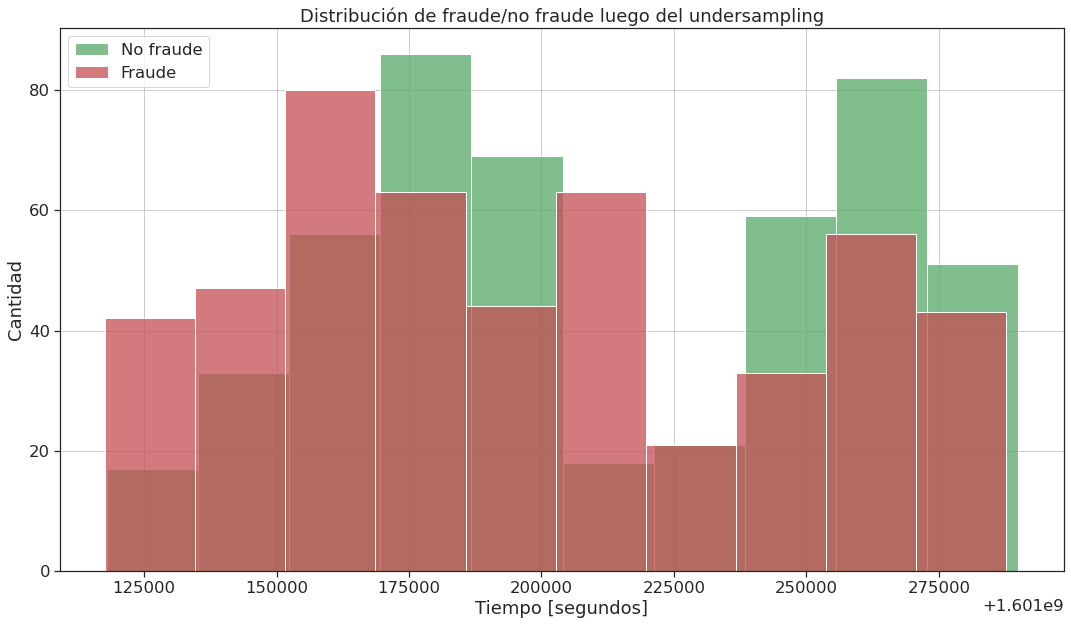

In [15]:
plot_class_distribution_in_time(df_downsampled,title='Distribución de fraude/no fraude luego del undersampling',
                                log=False)

In [16]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [17]:
non_feature_cols = ['time','row_id','class']
feature_cols = [x for x in df.columns if x not in non_feature_cols]
feature_cols

['v1',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6',
 'v7',
 'v8',
 'v9',
 'v10',
 'v11',
 'v12',
 'v13',
 'v14',
 'v15',
 'v16',
 'v17',
 'v18',
 'v19',
 'v20',
 'v21',
 'v22',
 'v23',
 'v24',
 'v25',
 'v26',
 'v27',
 'v28',
 'amount']

In [18]:
X = df_downsampled[feature_cols]
y = df_downsampled['class']

In [19]:
TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=1)

### 3. Ingeniería de features

#### 3.1 Análisis por correlación

En este análisis se intentará saber cuales son las características que influyen fuertemenete en una operación identificada como fraudulenta utilizando el coeficiente de correlación de Pearson. Es importante tener presente que en este análisis aún cuando una característica puede parecer no ser relevante, combinada con otra (u otras) sí podría serlo, y este aspecto pasaría desapercibido. Por lo tanto, no se deben descartar variables sólo porque aparenten tener una bajo coeficiente de correlación.

In [20]:
exclude_corr_cols = ['time','row_id'] # Exluímos el tiempo y el número de fila.
corr_cols = [x for x in df_downsampled.columns if x not in exclude_corr_cols]
df_downsampled_train = pd.concat([X_train, y_train], axis=1)

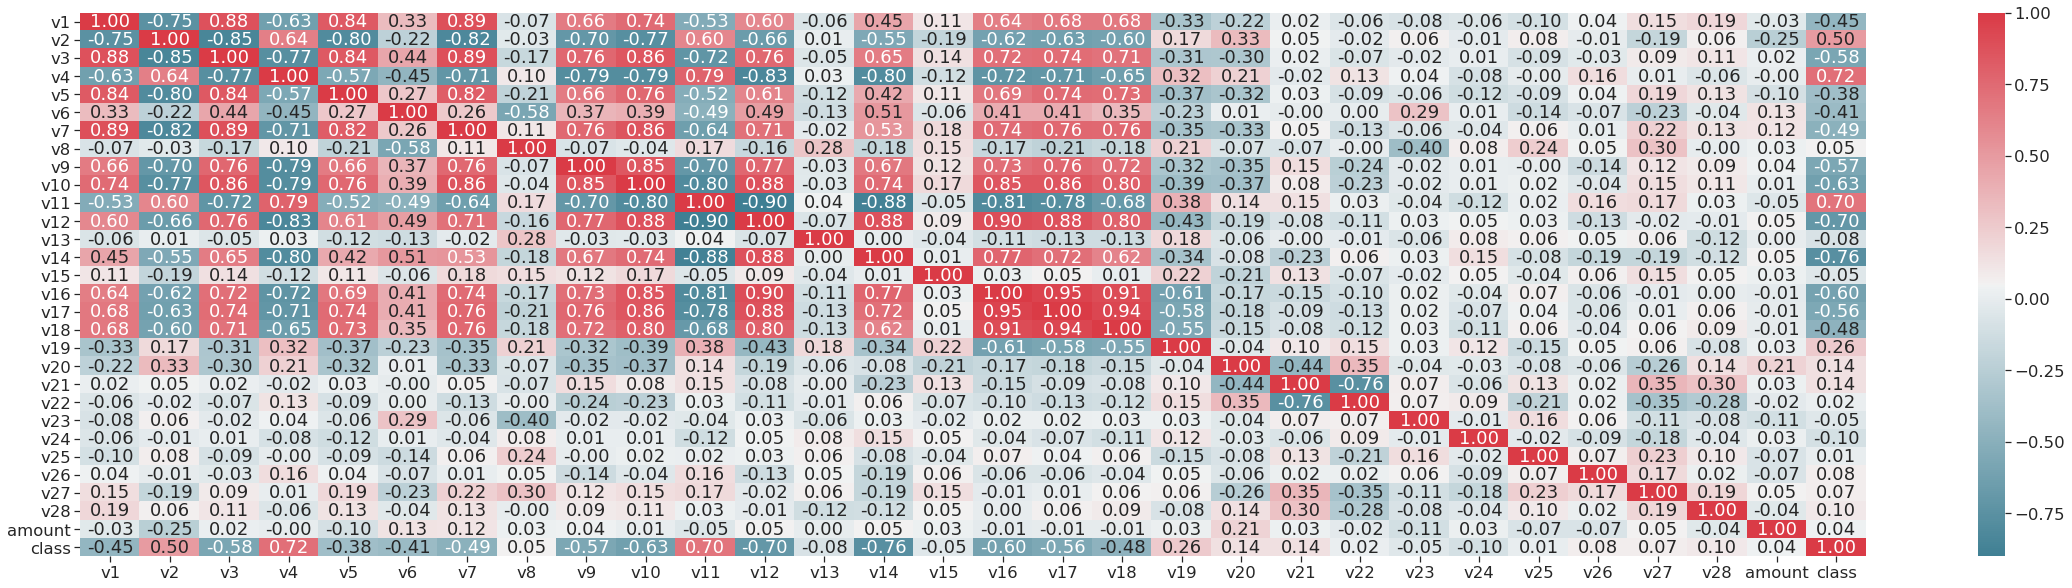

In [21]:
fig, ax1 = plt.subplots(1, figsize=(40,10))
corr = df_downsampled_train.corr() # Todo combinar con Y_train
sns.heatmap(corr, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f")
sns.set(font_scale=0.9)

##### Conclusiones

- **Correlación negativa**: v1, v3,v5,v6,v7,v9,v10,v12,v14,v16,v17,v18 tienen valores de correlación negativos. Valores negativos más extremos están correlacionados con mayor probabilidad de fraude.
- **Correlación positiva**: v2,v4,v11,v19 estan positivamente correlacionados. Los valores más altos indican mayor probabilidad de fraude.

Es de interés analizar como están distribuidos los valores de estas características para cada resultado de la clasificación.

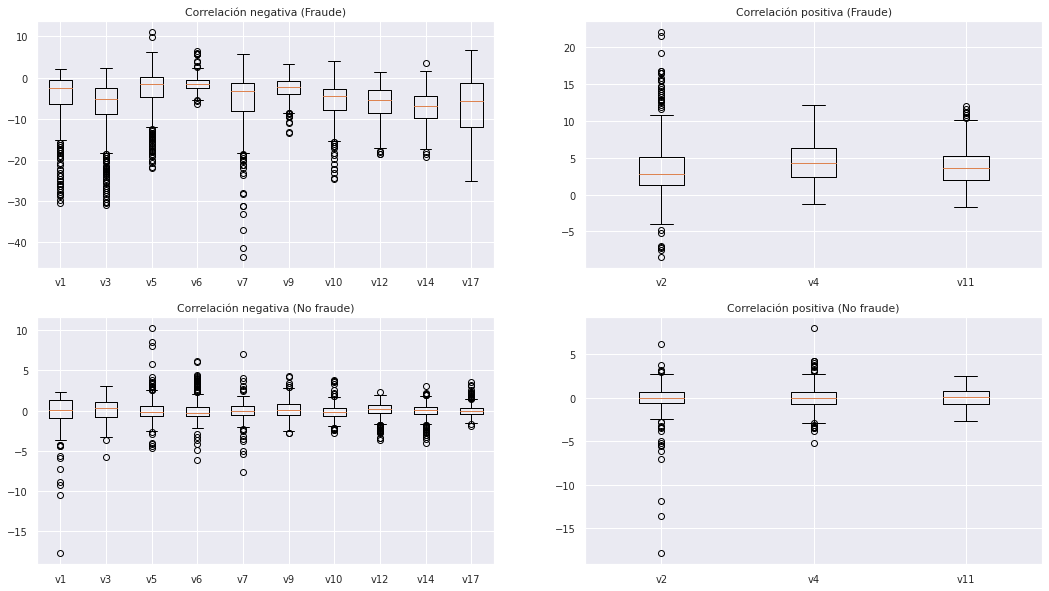

In [22]:
negative_corr = ['v1','v3','v5','v6','v7','v9','v10','v12','v14','v17']
positive_corr = ['v2','v4','v11']

pos_corr_plots_fraud = []
neg_corr_plots_fraud = []
pos_corr_plots_no_fraud = []
neg_corr_plots_no_fraud = []

for x in negative_corr:
    neg_corr_plots_fraud.append(df_downsampled_train.loc[df_downsampled_train['class']==1,x])
    neg_corr_plots_no_fraud.append(df_downsampled_train.loc[df_downsampled_train['class']==0,x])
    
for x in positive_corr:
    pos_corr_plots_fraud.append(df_downsampled_train.loc[df_downsampled_train['class']==1,x])
    pos_corr_plots_no_fraud.append(df_downsampled_train.loc[df_downsampled_train['class']==0,x])    

fig, axes = plt.subplots(2,2, figsize=(18,10))

axes[0][0].set_title("Correlación negativa (Fraude)")
axes[0][0].boxplot( neg_corr_plots_fraud )
axes[0][0].set_xticklabels(negative_corr)

axes[0][1].set_title("Correlación positiva (Fraude)")
axes[0][1].boxplot( pos_corr_plots_fraud )
axes[0][1].set_xticklabels(positive_corr)

axes[1][0].set_title("Correlación negativa (No fraude)")
axes[1][0].boxplot( neg_corr_plots_no_fraud)
axes[1][0].set_xticklabels(negative_corr)

axes[1][1].set_title("Correlación positiva (No fraude)")
axes[1][1].boxplot(pos_corr_plots_no_fraud)
axes[1][1].set_xticklabels(positive_corr)

plt.show()

Es de interés observar en los diagramas anteriores si hay variables que tengan un bajo grado de solapamiento en sus distribuciones para cada una de las clases, sugiriendo que son candidatos a ser buenos clasificadores. Destacan las columnas v2, v4 y v11 (como ya se vió en los resultados de la correlación anterior).

#### 3.2 Análisis por Random Forest

Otro método para obtener aquellas características que influyan más en el resultado es aprovechando la selección de parámetros que hace el algoritmo Random Forest.

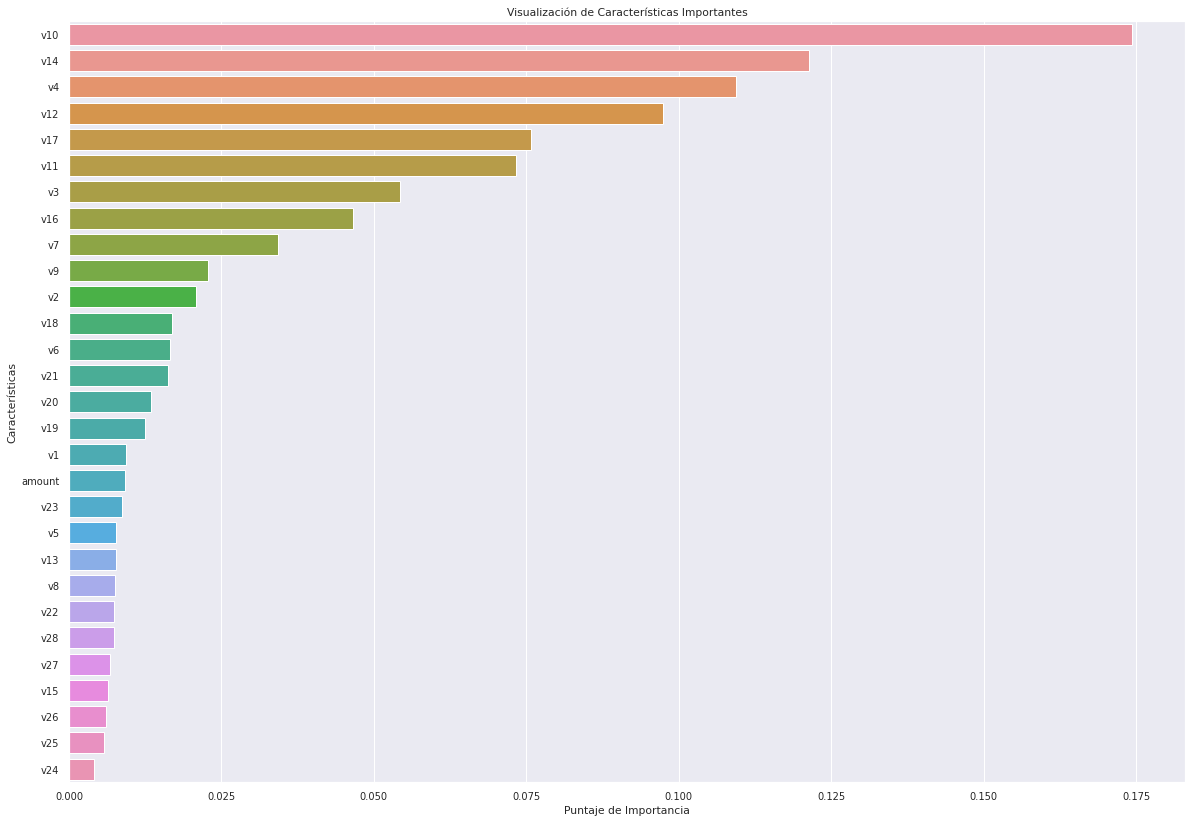

In [23]:
clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
clf.fit(X_train,y_train)

feature_imp = pd.Series(clf.feature_importances_,index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(20,14))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Puntaje de Importancia')
plt.ylabel('Características')
plt.title("Visualización de Características Importantes")
plt.show()

#### 3.3 Clustering

Se hara un estudio sencillo aplicando compresión PCA de si se observa un patrón evidente de separación entre clases, y se hará una prueba muy básica de clasificación utilizando K-Means.

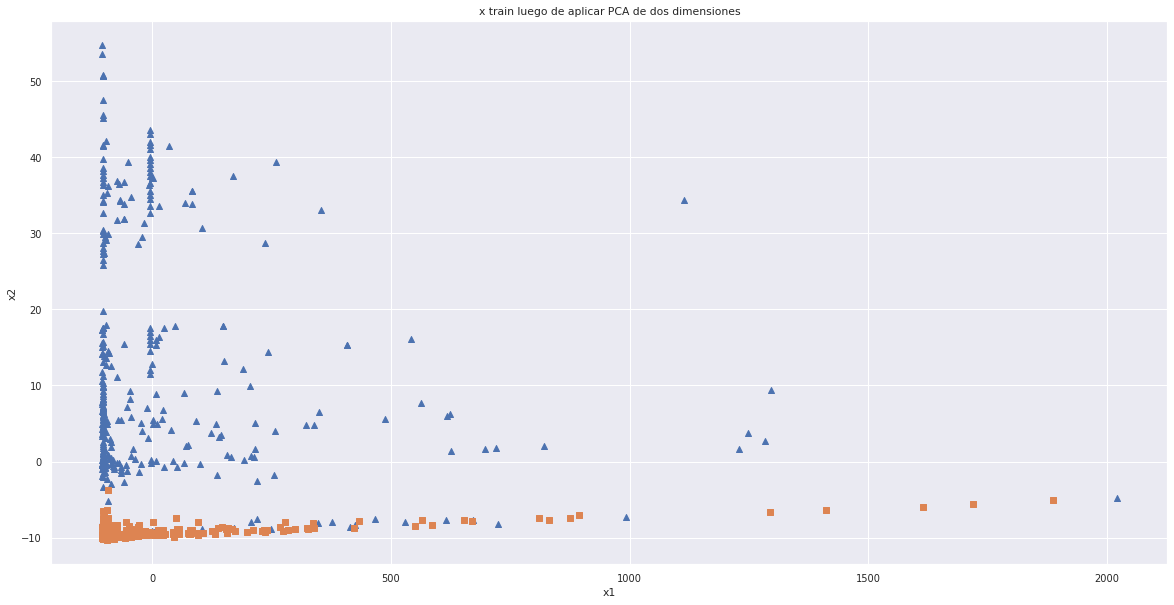

In [24]:
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

X_train_pca_positive = X_train_pca[y_train > 0.5]
X_train_pca_negative = X_train_pca[y_train < 0.5]

plt.figure(figsize=(20,10))
plt.scatter(X_train_pca_positive[:,0], X_train_pca_positive[:,1],marker="^")
plt.scatter(X_train_pca_negative[:,0], X_train_pca_negative[:,1],marker="s")
plt.title('x train luego de aplicar PCA de dos dimensiones')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

<AxesSubplot:>

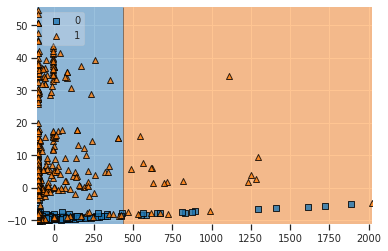

In [25]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2, random_state=100).fit(X_train_pca)
plot_decision_regions(X_train_pca,y_train.values.astype(int),model,legend=2)

### 4. Entrenamiento de modelos

En esta sección se procederá a entrenar distintos tipos de modelos, en algunos casos ensayando distintas variantes de parámetros para cada uno:

- No Supervisados
    - **K-Means**
- Supervisados
    - **Árboles de decisión**.
    - **Random Forest**.
    - **Regresión Logística**.
    - **Support Vector Machine**.
    - **Multi-layer Perceptron**.
    - **XGBoost**.

##### Criterio de evaluación. 

Para todos los modelos se obtendrán métricas relevantes para la clasificación binaria:

- **Accuracy**: Ratio de observaciones correctas sobre total de observaciones. $\frac{TP+TN}{TP+FP+FN+TN}$. Dado que se ha aplicado undersampling a los datos para balancearlos, esta métrica puede usarse. De mantenerse el dataset imbalanceado esta métrica puede dar una interpretación errónea del desempeño del algoritmo.
- **Precision**: $\frac{TP}{TP+FP}$. Se relaciona con una baja tasa de falsos positivos.
- **Recall**: $\frac{TP}{TP+FN}$. Mide la cantidad de predicciones correctas para cada clase. De todos los casos de fraude, ¿cuántos fueron correctamente identificados?.
- **Curva ROC**: La curva ROC indica qué tan capaz es un modelo de distinguir clases relacionando la tasa de falsos positivos con la tasa de verdaderos positivos.
- **AUC**: el Área bajo la Curva ROC es un indicador de qué tan bueno es un clasificador independientemente del umbral de clasificación elegido.
- **f1-score**: Promedio entre Precision y Recall. $2\frac{Recall x Precision}{Recall + Precision}$
- **Matriz de Confusión:**: es una forma de visualizar para cada clase TP,TN,FP y FN.

Siendo:
- TP (True Positives): casos de Fraude identificados como Fraude.
- TN (True Negatives): casos de No fraude identificados como No Fraude.
- FP (False Positives): casos de No Fraude identificados como Fraude.
- FN (False Negatives): casos de Fraude identificados como No Fraude.

In [26]:
from sklearn.metrics import plot_confusion_matrix

def model_evaluation_report(model,y_test,y_pred,y_pred_prob,description):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,zero_division=False)
    recall = metrics.recall_score(y_test, y_pred)
        
    #fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[4, 3]))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob[:,1])
    auc = metrics.auc(fpr, tpr)
    f1_score = metrics.f1_score(y_test, y_pred)
    
    fig, axes = plt.subplots(1,2,figsize=(20,10))
    plot_confusion_matrix(model, X_test, y_test,ax=axes[0])  # doctest: +SKIP
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel('Predicción')
    axes[0].set_ylabel('Etiqueta real')
    #plt.show()
    
    #plt.figure()
    axes[1].plot(fpr, tpr)
    axes[1].set_title("Curva ROC")
    axes[1].set_xlabel('Tasa de falsos positivos (1 - Especificidad)')
    axes[1].set_ylabel('Tasa de positivos (Sensibilidad)')
    plt.show()   
            
    print("AUC:", auc )
    print("Accuracy:", accuracy )
    print("Precision:", precision )
    print("Recall:", recall)
    print("f1-score: ", f1_score)
    
    model_summary={
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "auc": auc,
        "f1-score": f1_score,
        "description": description
    }
    return model_summary

Los modelos serán exportados para poder servirse con una API REST.

In [27]:
def save_model(model, model_filename):    
    joblib.dump(model, MODELS_PATH+model_filename)

In [28]:
# Para futura tabla comparativa
model_metrics_list = {}

Todos los modelos serán comparados contra un modelo base que representa un clasificador que implementa una estrategida de clasificación nula. En este caso se decidió, por tratarse de un dataset imbalanceado, que el modelo base repita el valor de salida más frecuente.

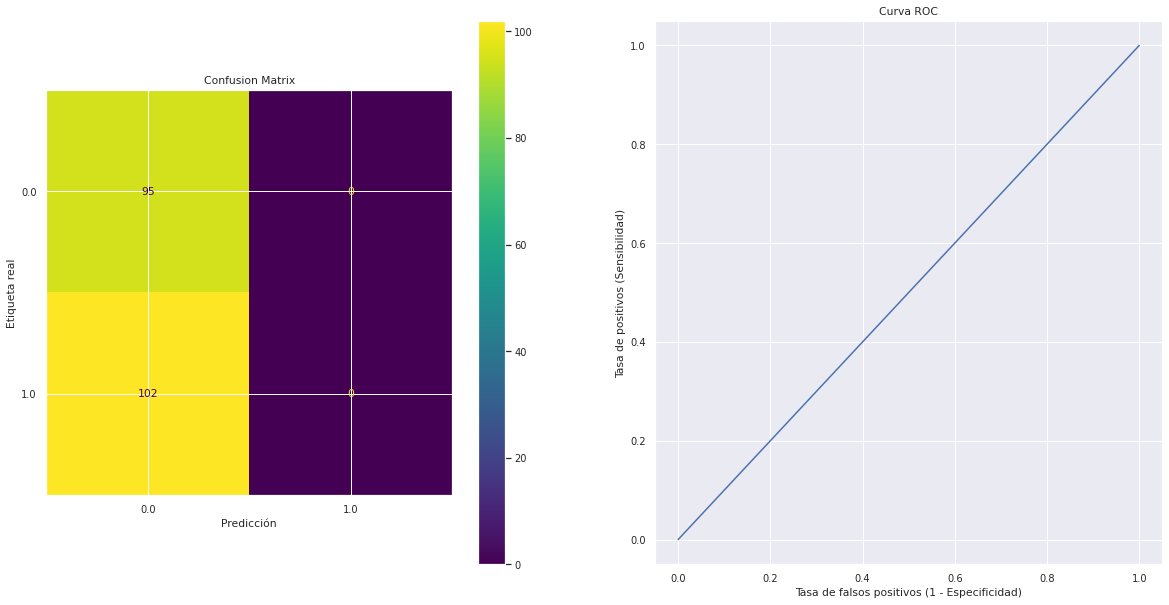

AUC: 0.5
Accuracy: 0.48223350253807107
Precision: 0.0
Recall: 0.0
f1-score:  0.0


In [29]:
from sklearn.dummy import DummyClassifier 

model = DummyClassifier(strategy='most_frequent')
model = model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

model_name = "base"
description = "Modelo base"
model_metrics_list[model_name] = model_evaluation_report(model,y_test,y_pred,y_pred_prob,description)
save_model(model,model_name+".pkl")

#### 4.1 Árboles de decisión

Se comenzará entrenando modelos de árboles de decisión ensayando algunos juegos de parámetros de criterio y profundidad.

In [30]:
from sklearn.tree import DecisionTreeClassifier
from six import StringIO
from IPython.display import display, Image,HTML
from sklearn.tree import export_graphviz
import pydotplus


def plot_and_save_tree_diagrams(model, name):
    dot_data = StringIO()
    export_graphviz( model, out_file=dot_data,  filled=True, rounded=True, special_characters=True,
                    feature_names = feature_cols,
                    class_names=['No fraude','Fraude'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png(TMP_PATH+name+'_tree.png')
    display(Image(graph.create_png()))

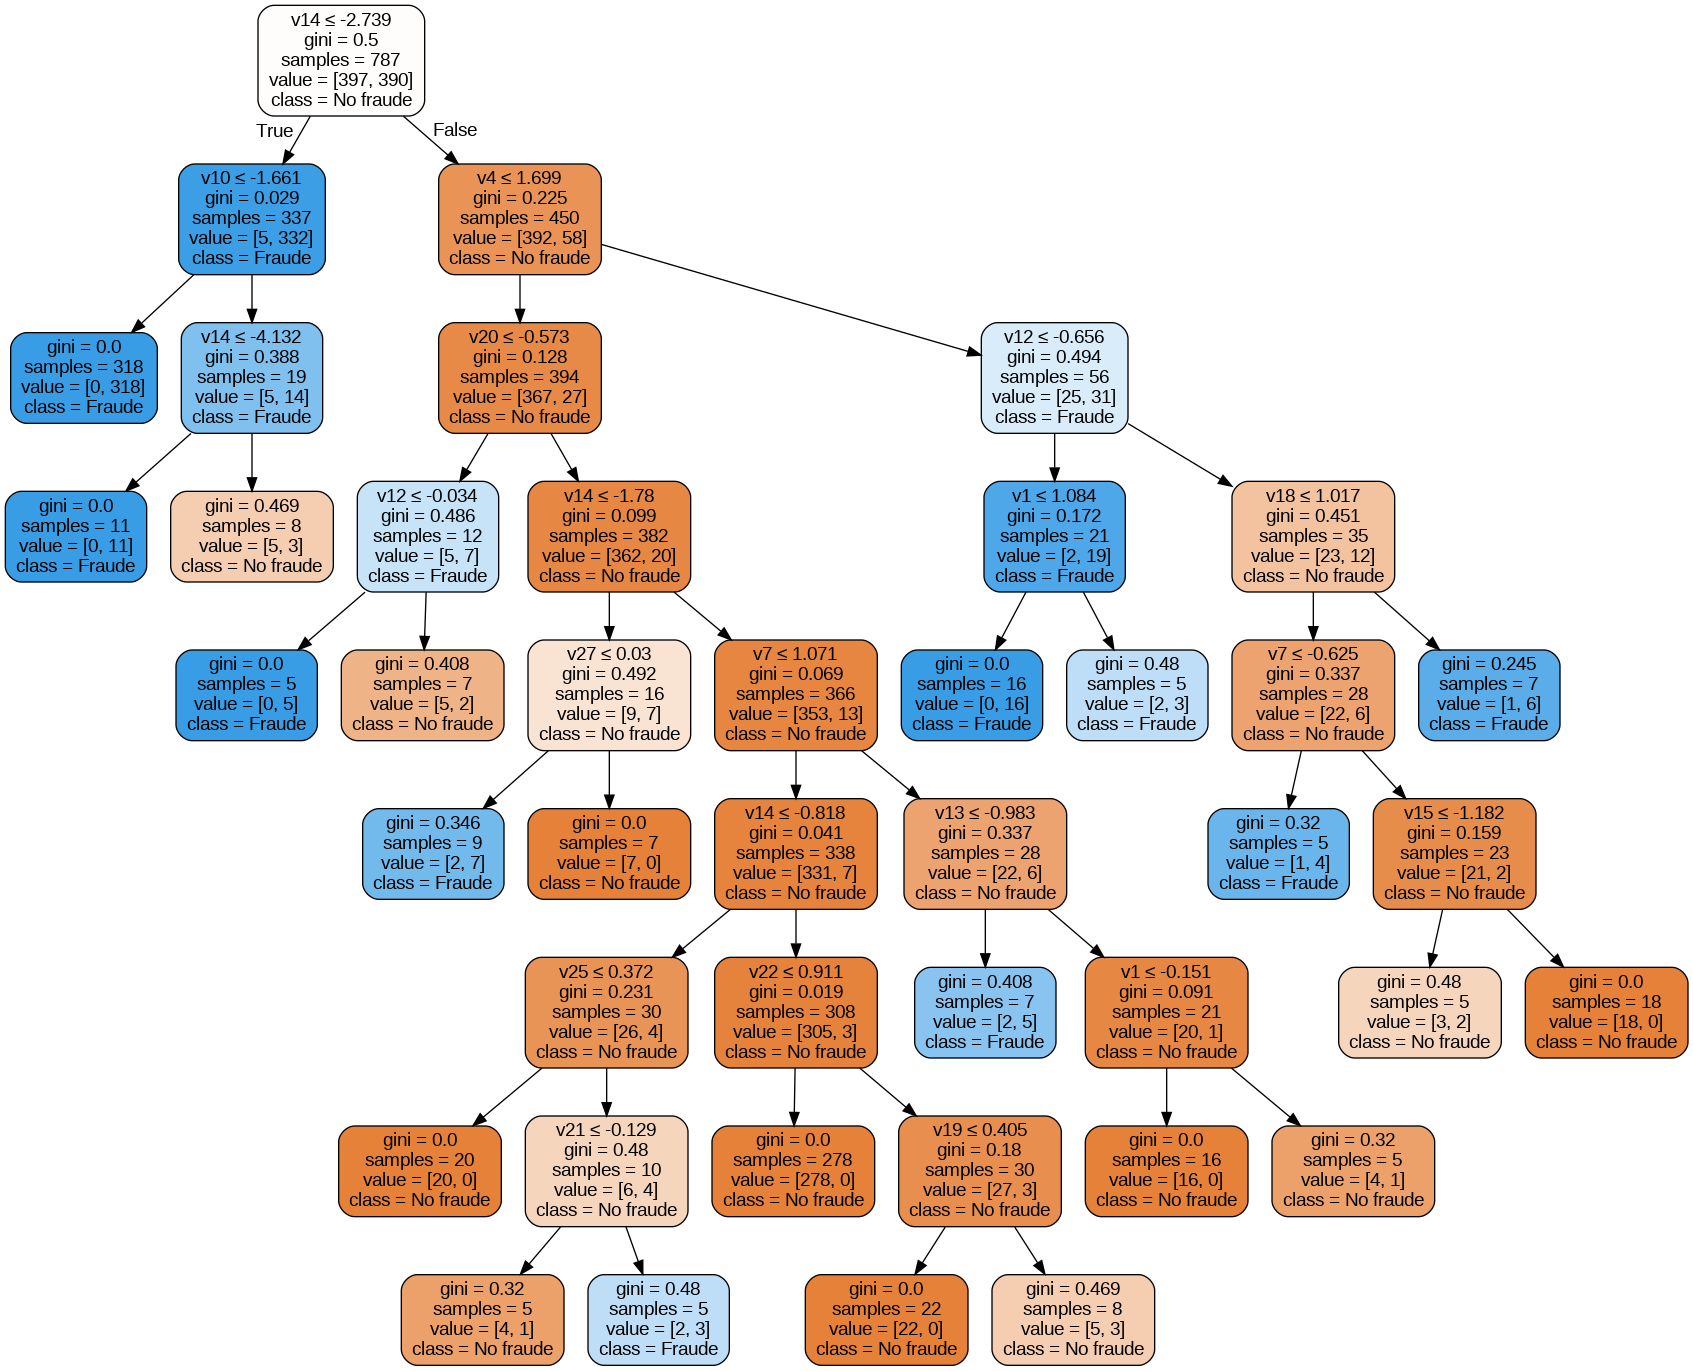

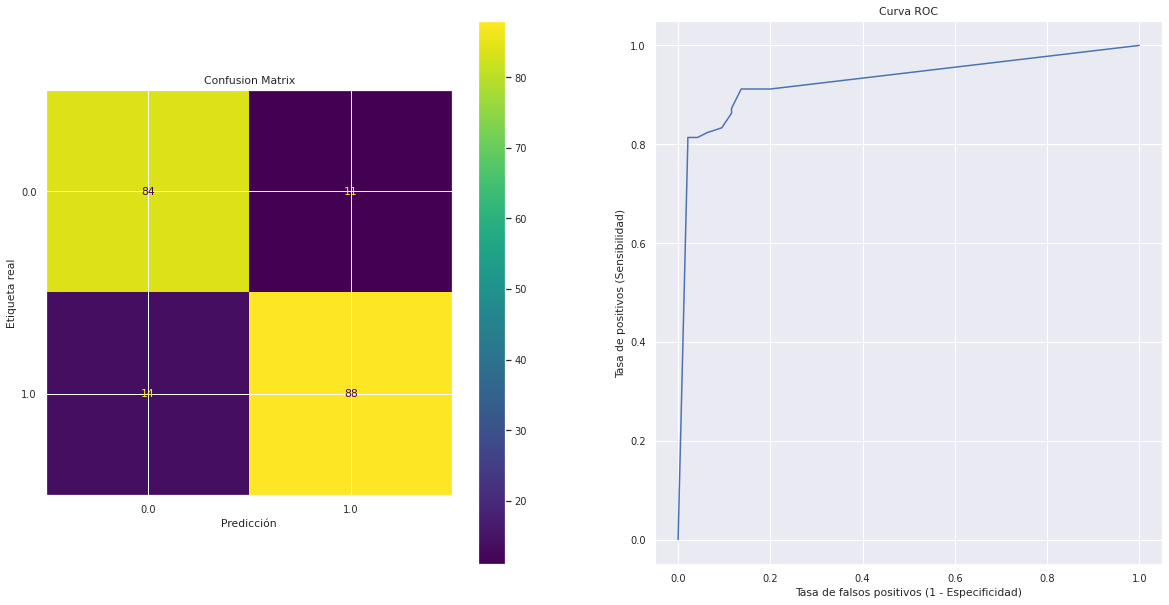

AUC: 0.9279153766769865
Accuracy: 0.8730964467005076
Precision: 0.8888888888888888
Recall: 0.8627450980392157
f1-score:  0.8756218905472637


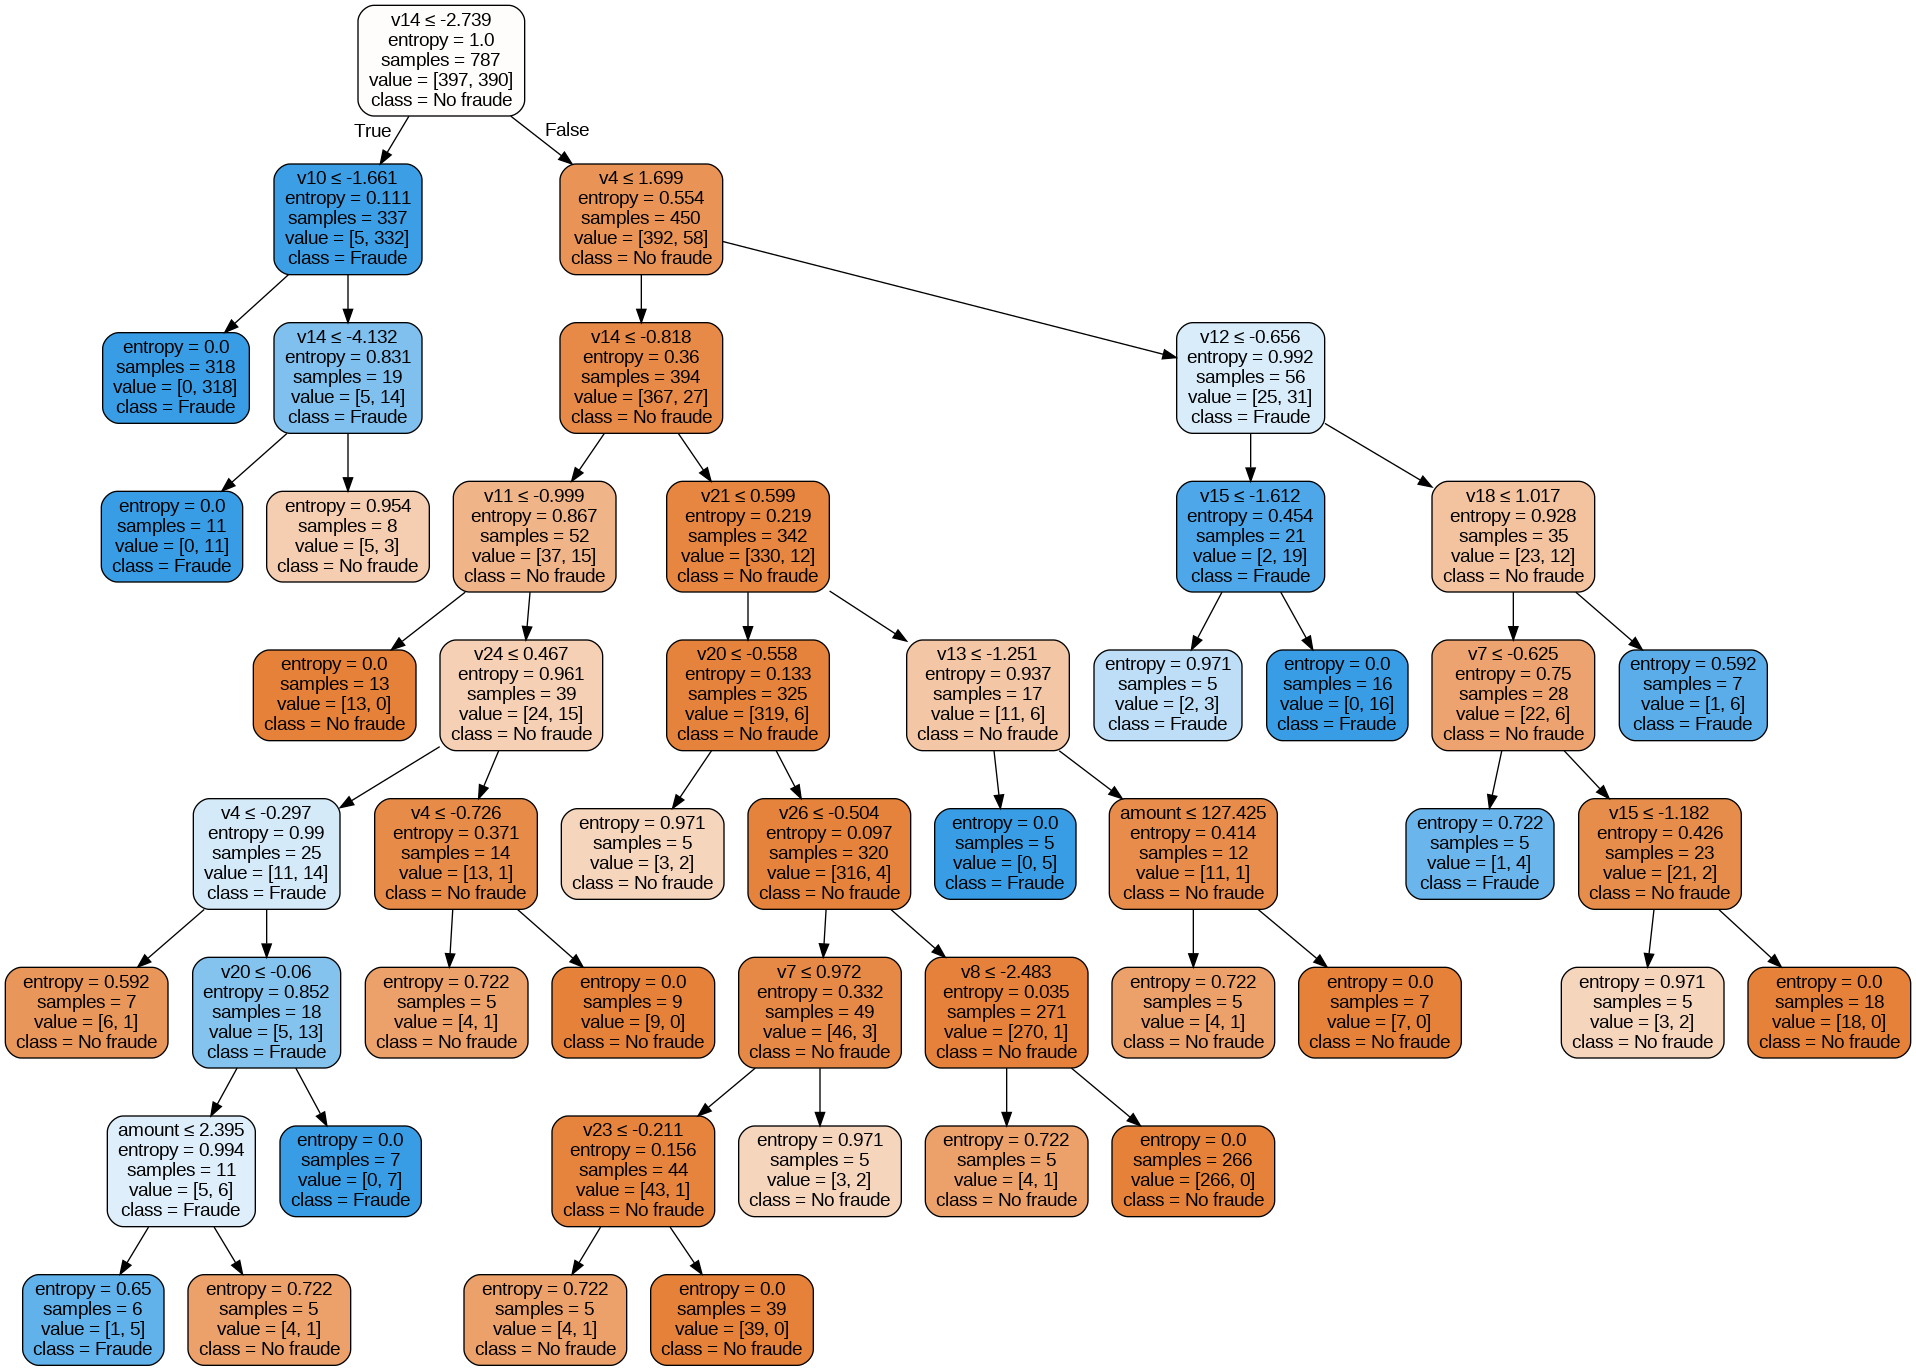

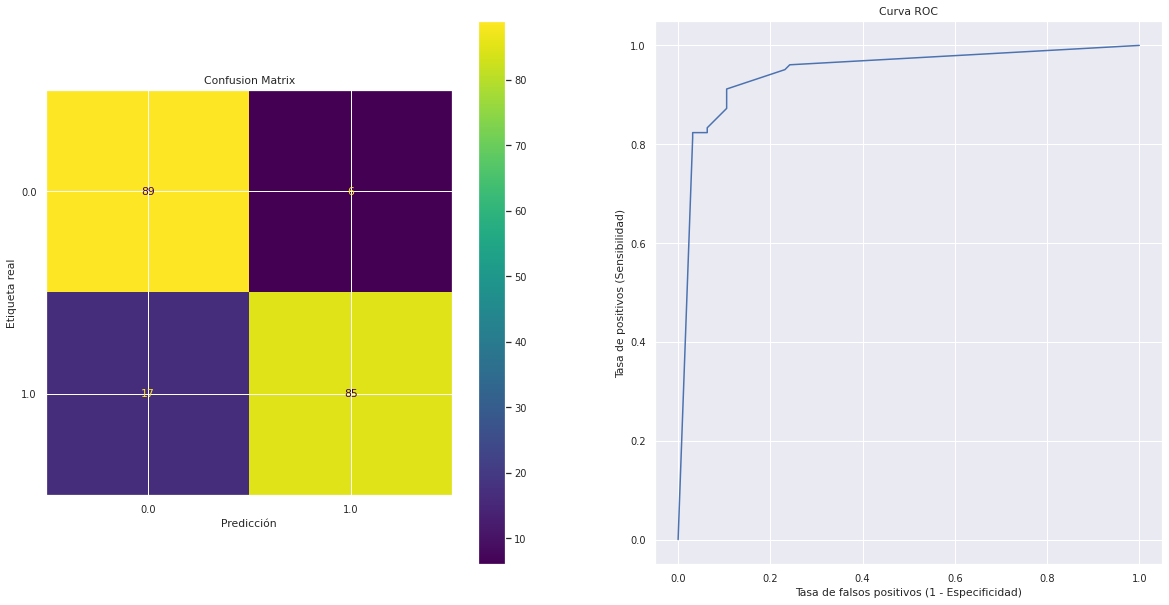

AUC: 0.9455108359133128
Accuracy: 0.883248730964467
Precision: 0.9340659340659341
Recall: 0.8333333333333334
f1-score:  0.8808290155440415


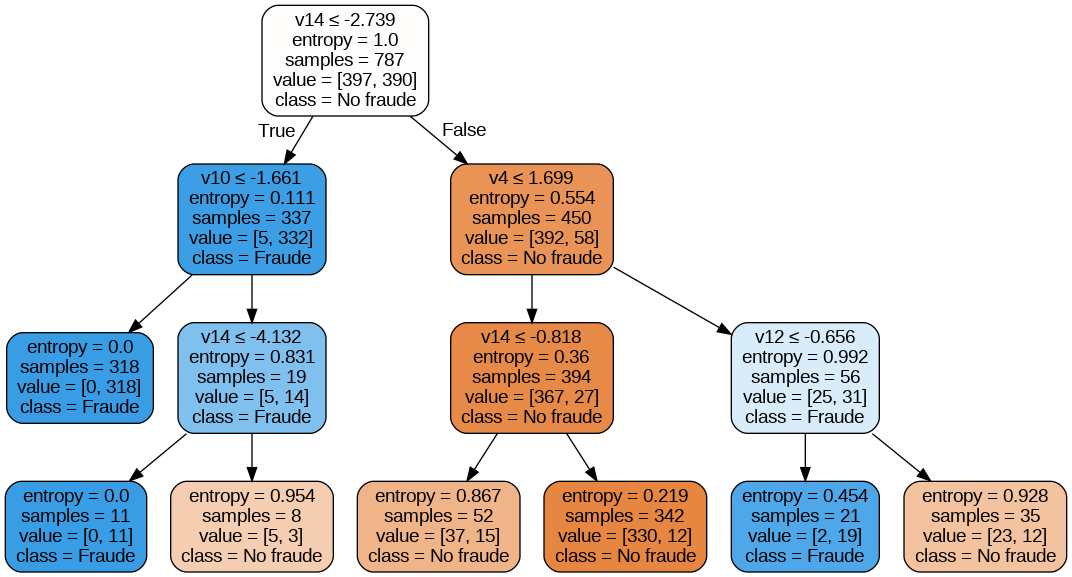

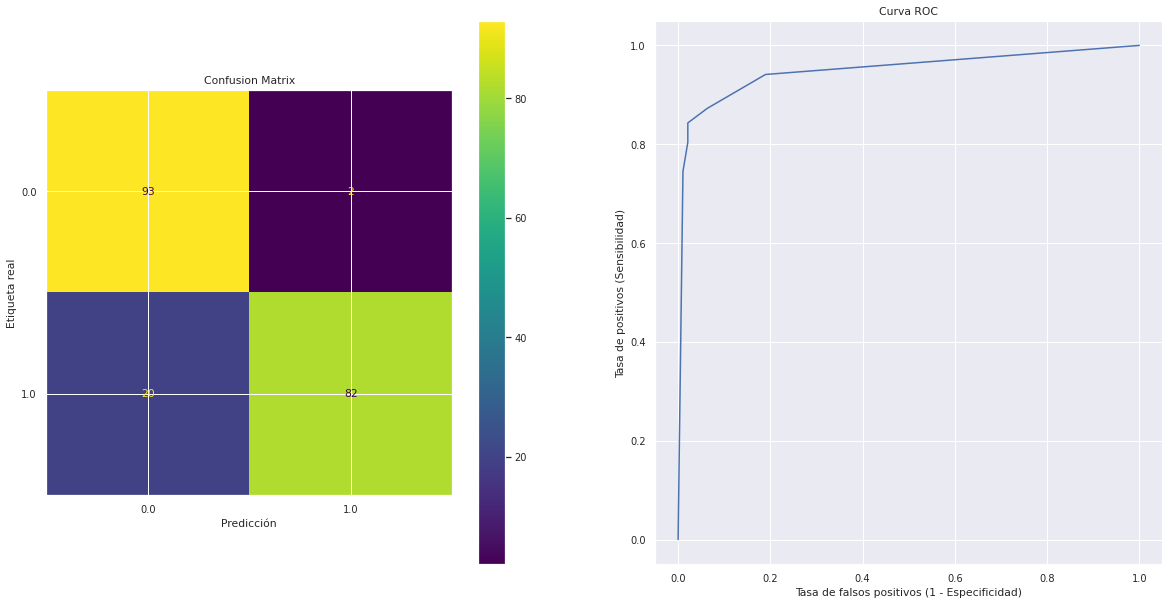

AUC: 0.9494324045407636
Accuracy: 0.8883248730964467
Precision: 0.9761904761904762
Recall: 0.803921568627451
f1-score:  0.8817204301075269


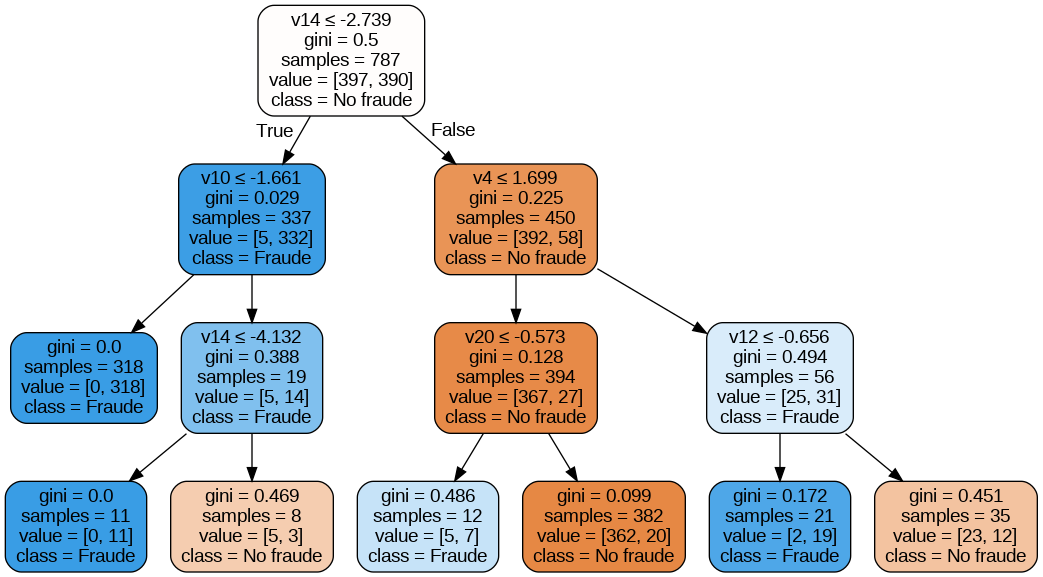

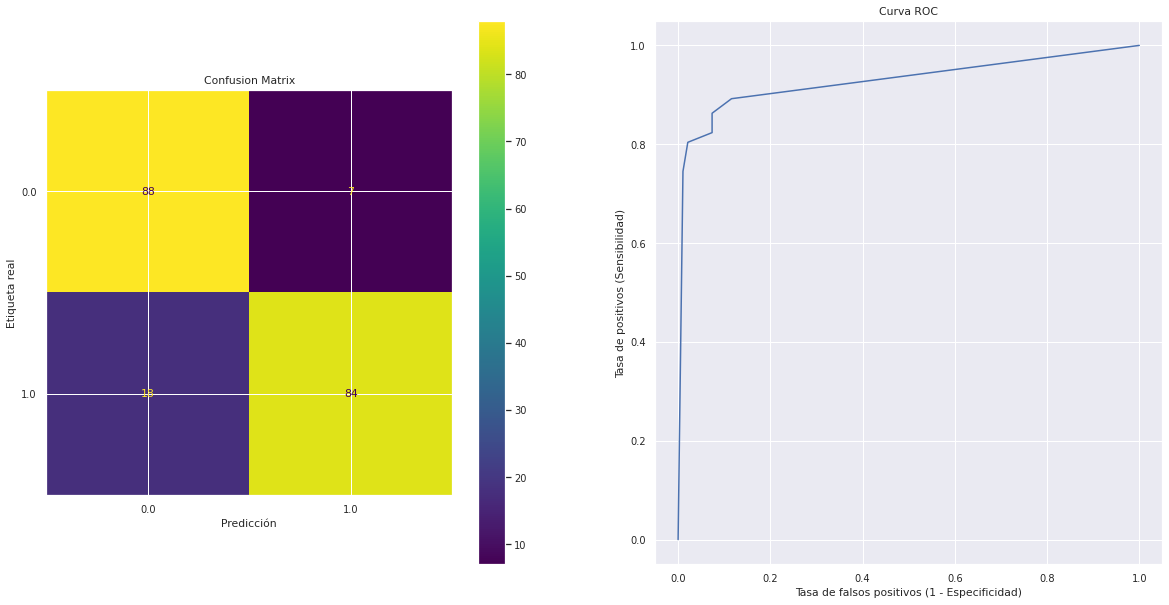

AUC: 0.9283797729618163
Accuracy: 0.8730964467005076
Precision: 0.9230769230769231
Recall: 0.8235294117647058
f1-score:  0.8704663212435233


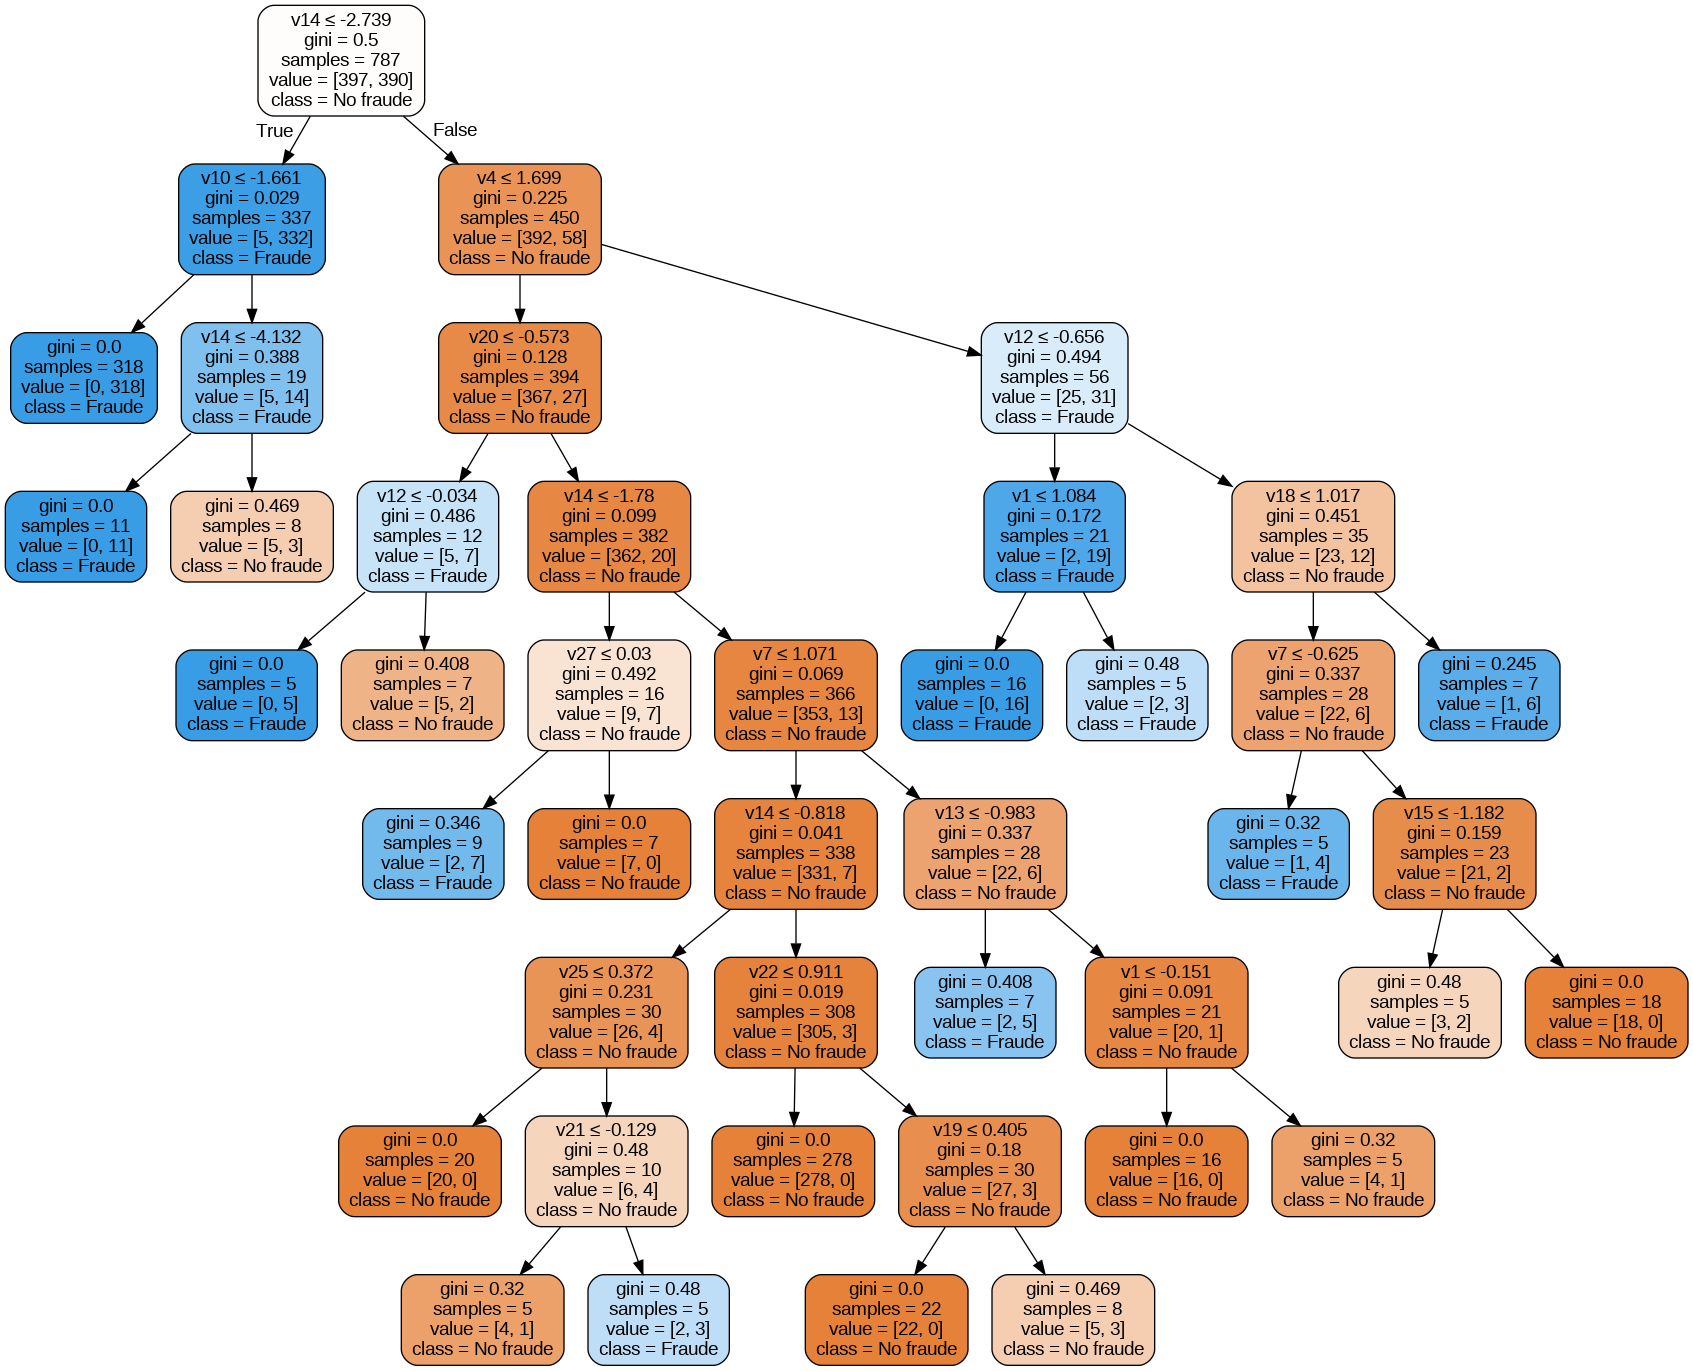

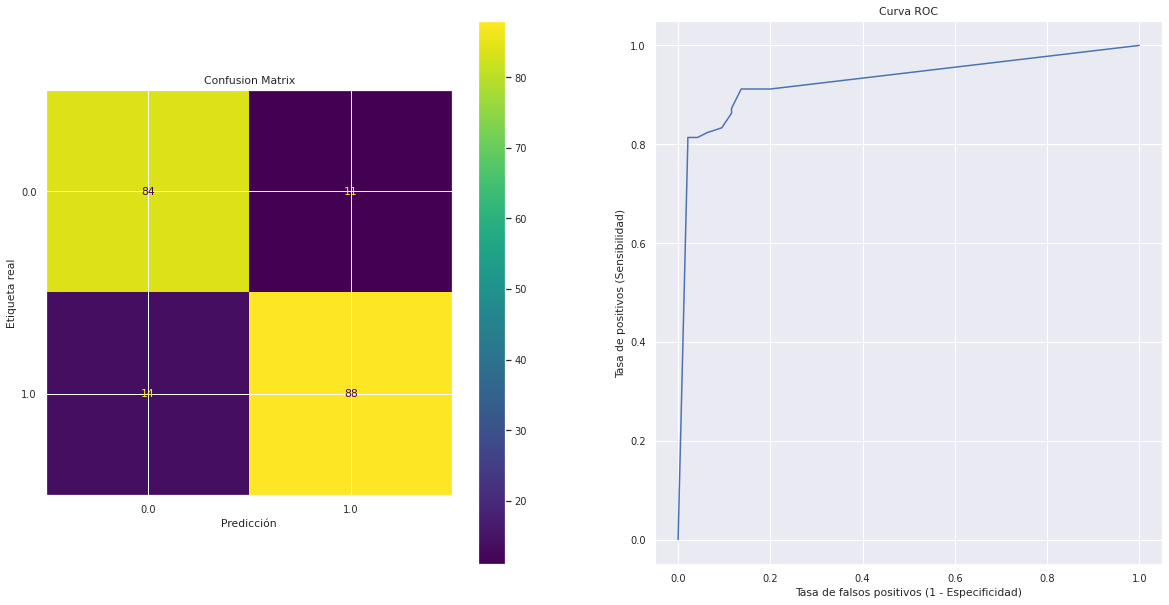

AUC: 0.9279153766769865
Accuracy: 0.8730964467005076
Precision: 0.8888888888888888
Recall: 0.8627450980392157
f1-score:  0.8756218905472637


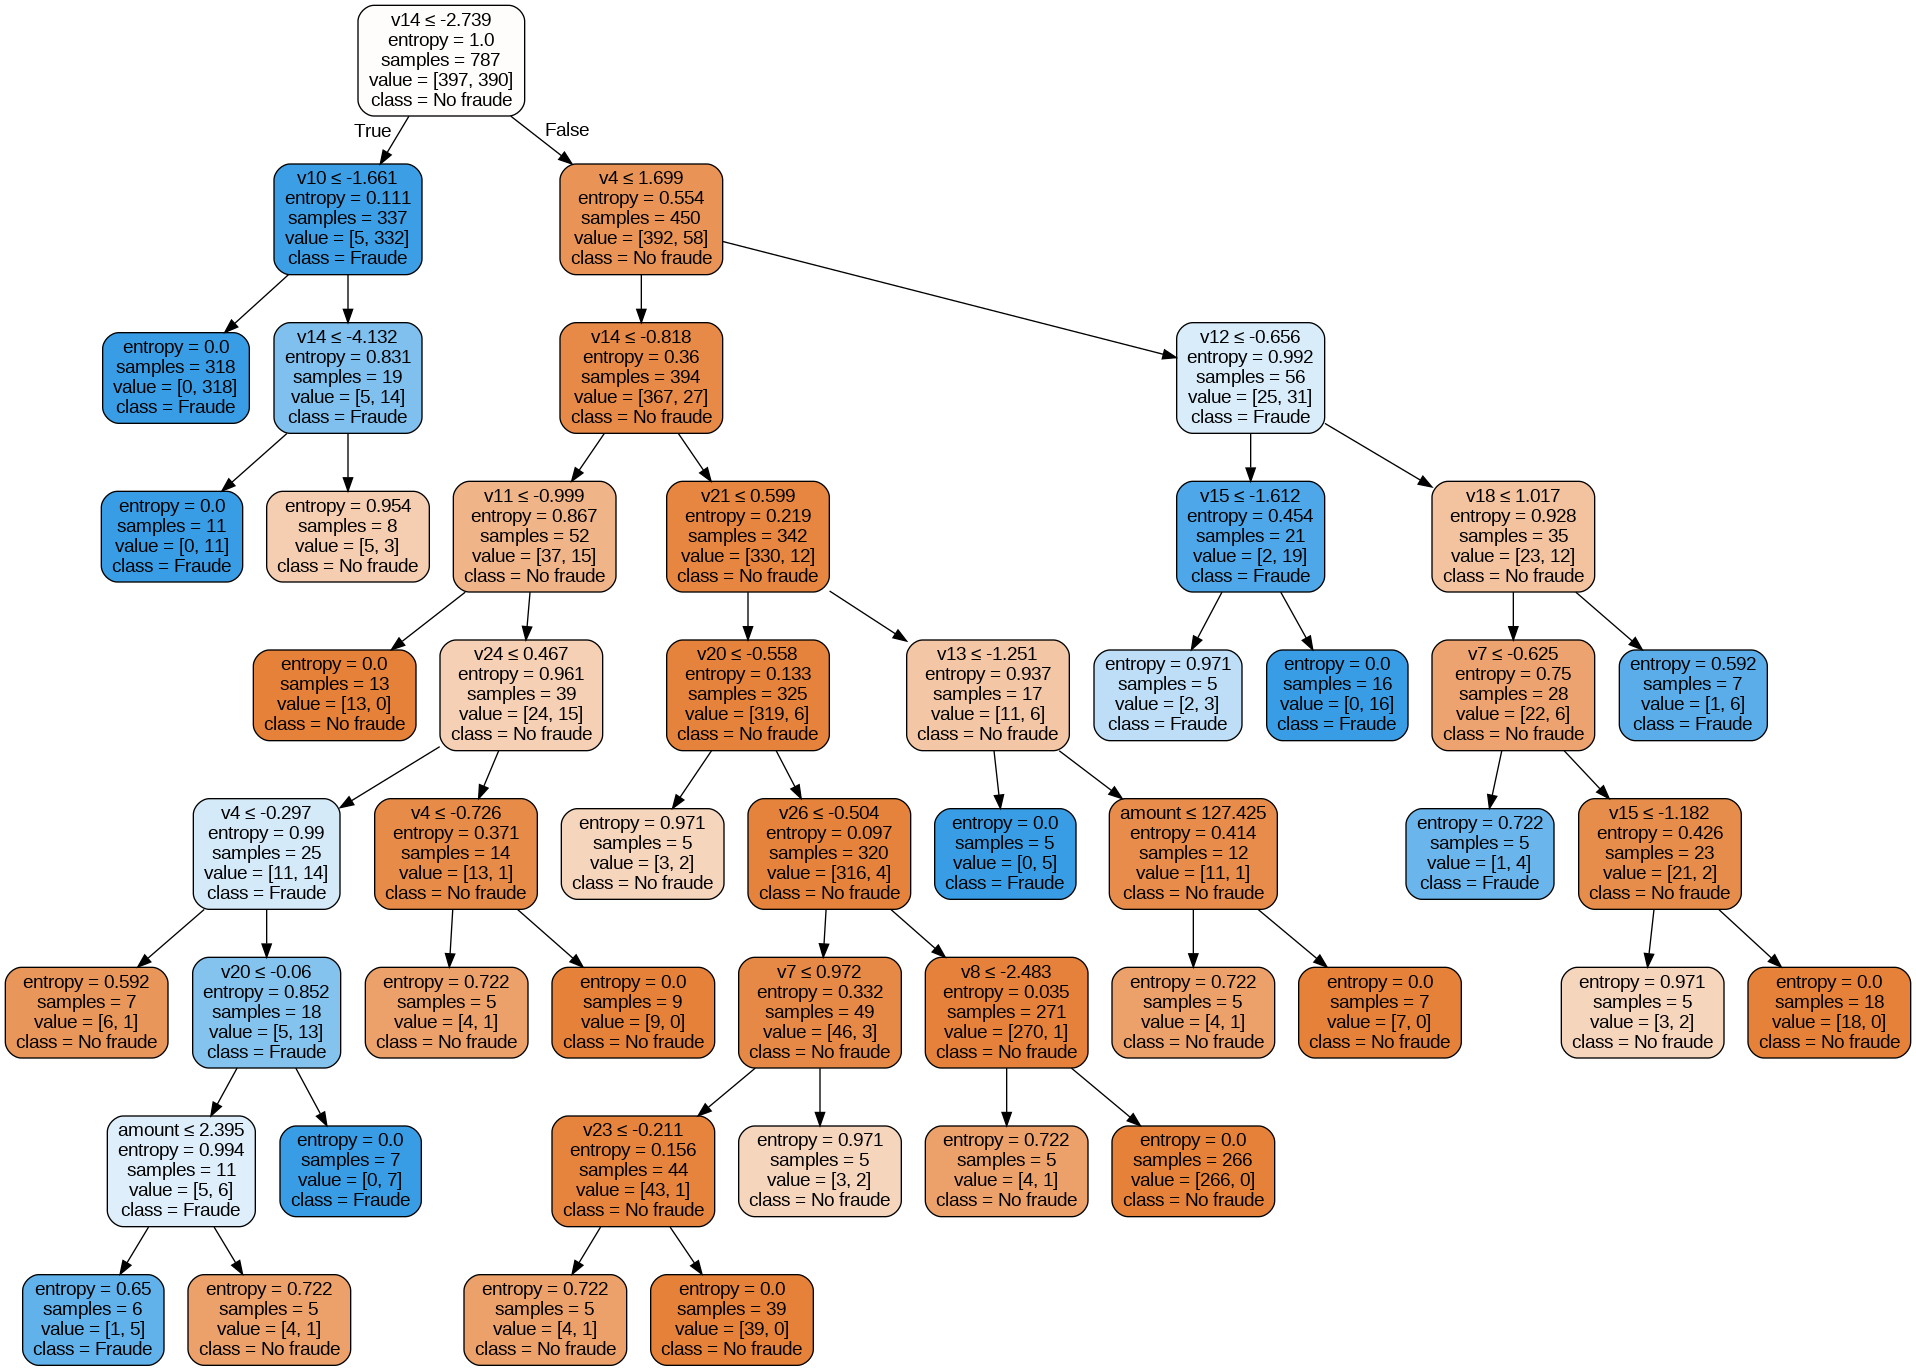

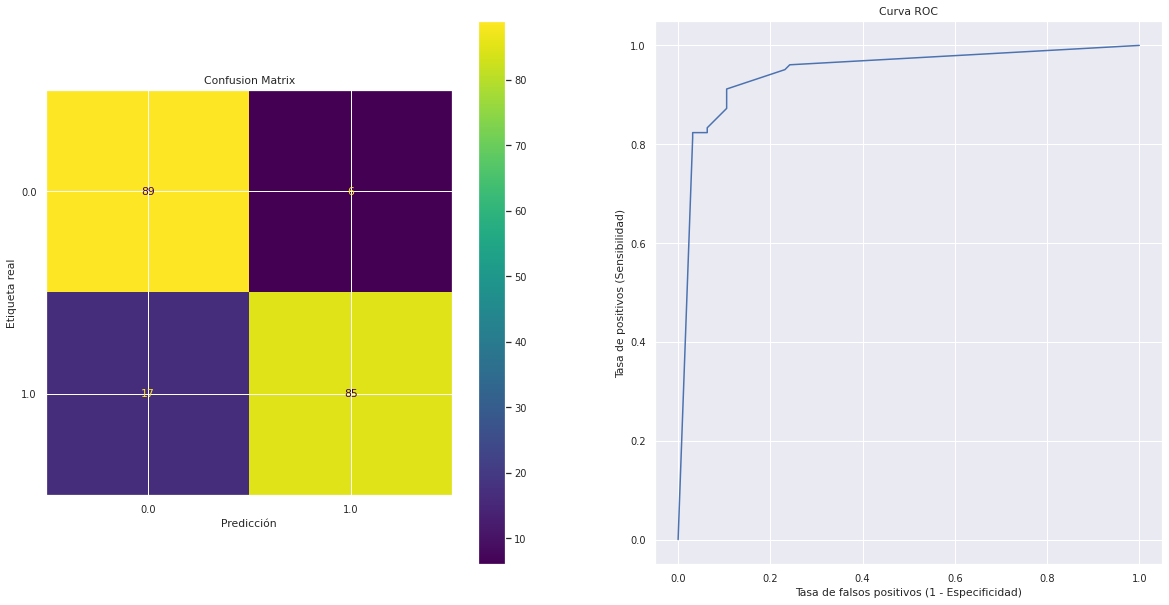

AUC: 0.9455108359133128
Accuracy: 0.883248730964467
Precision: 0.9340659340659341
Recall: 0.8333333333333334
f1-score:  0.8808290155440415


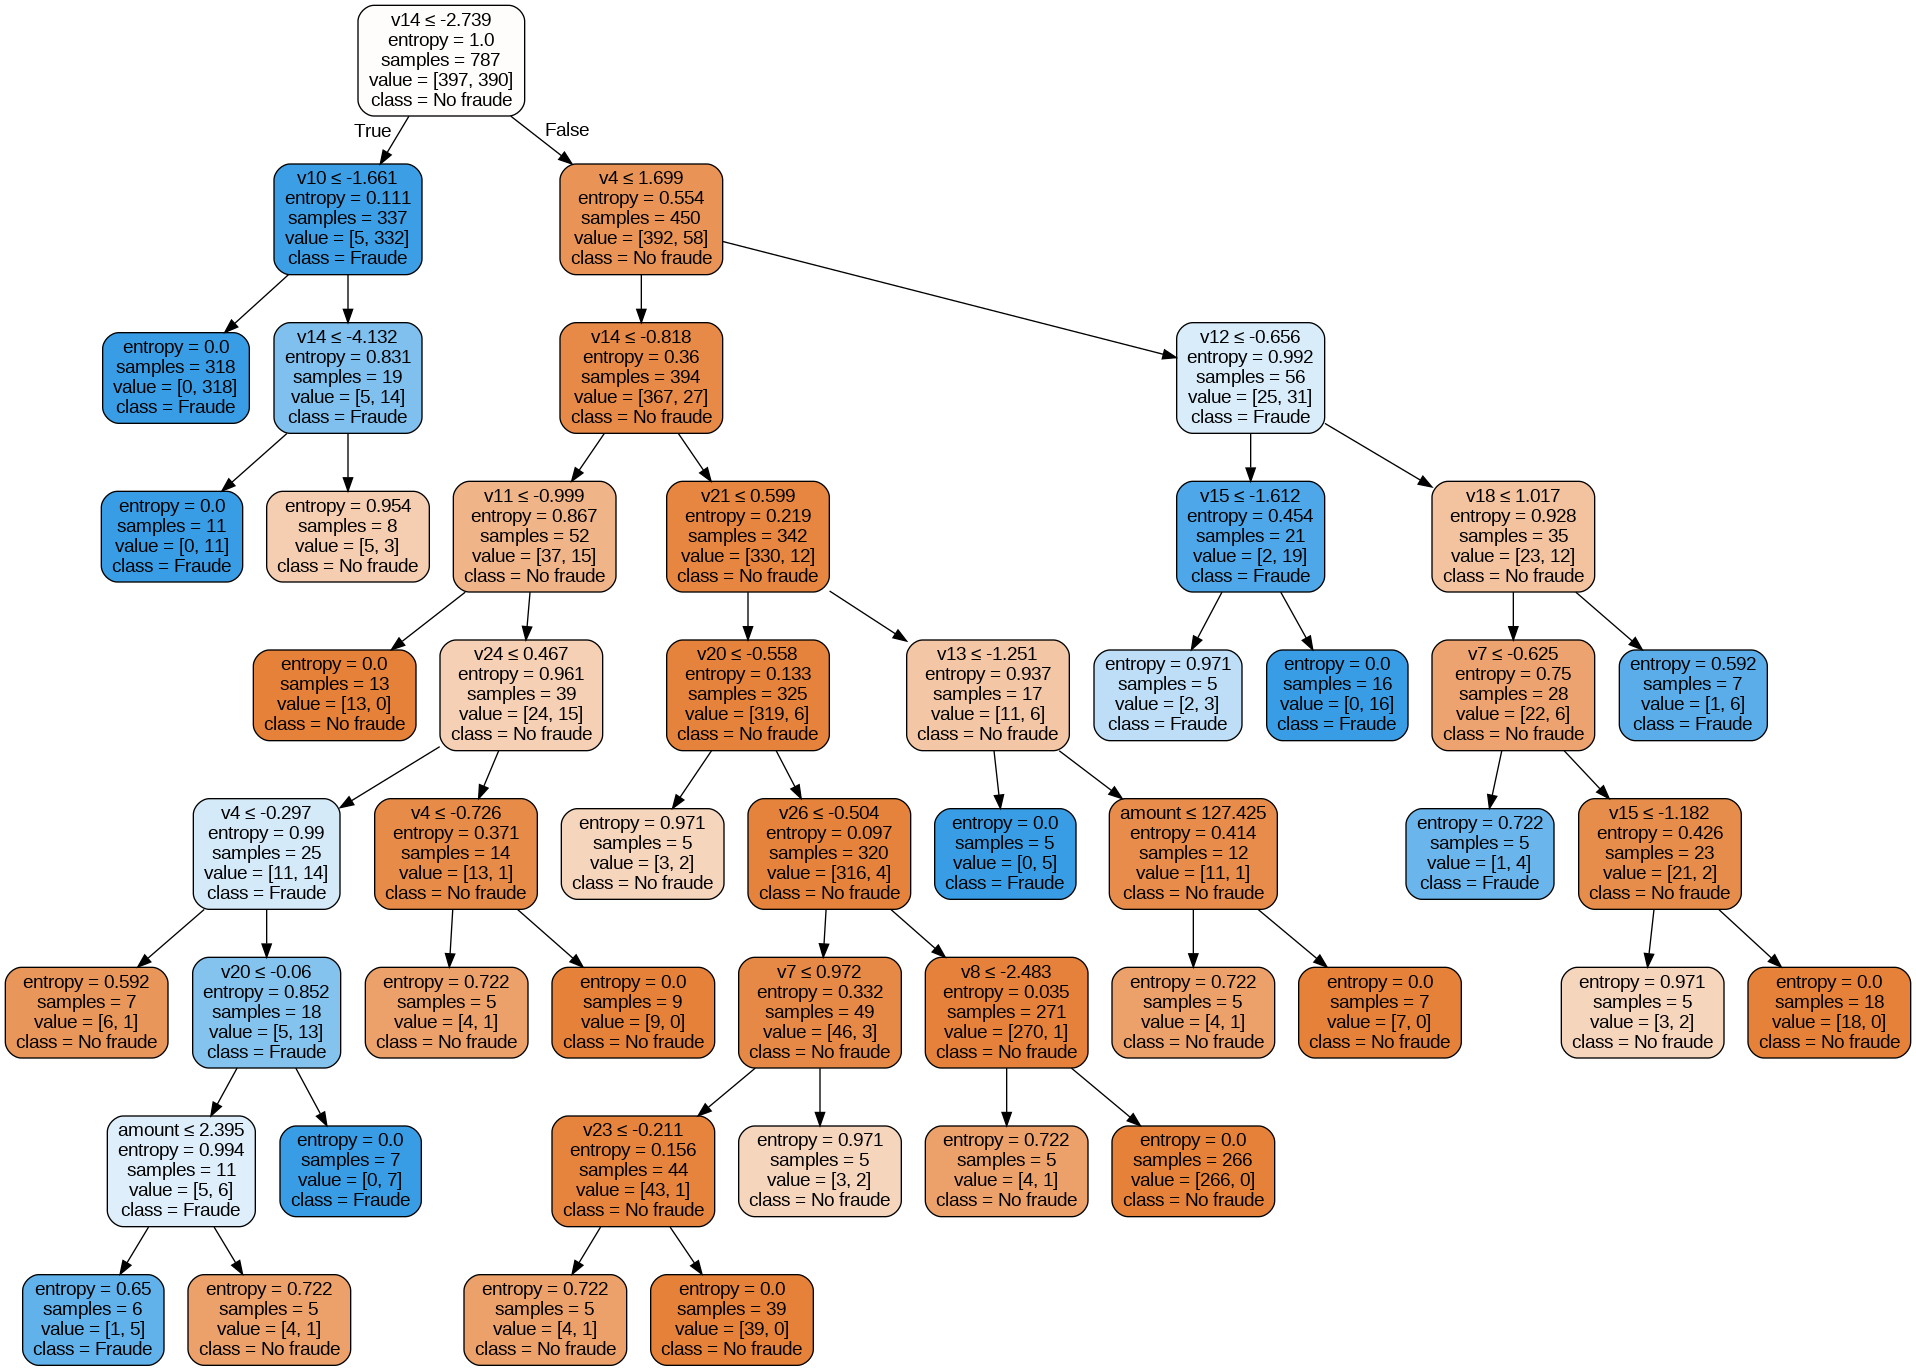

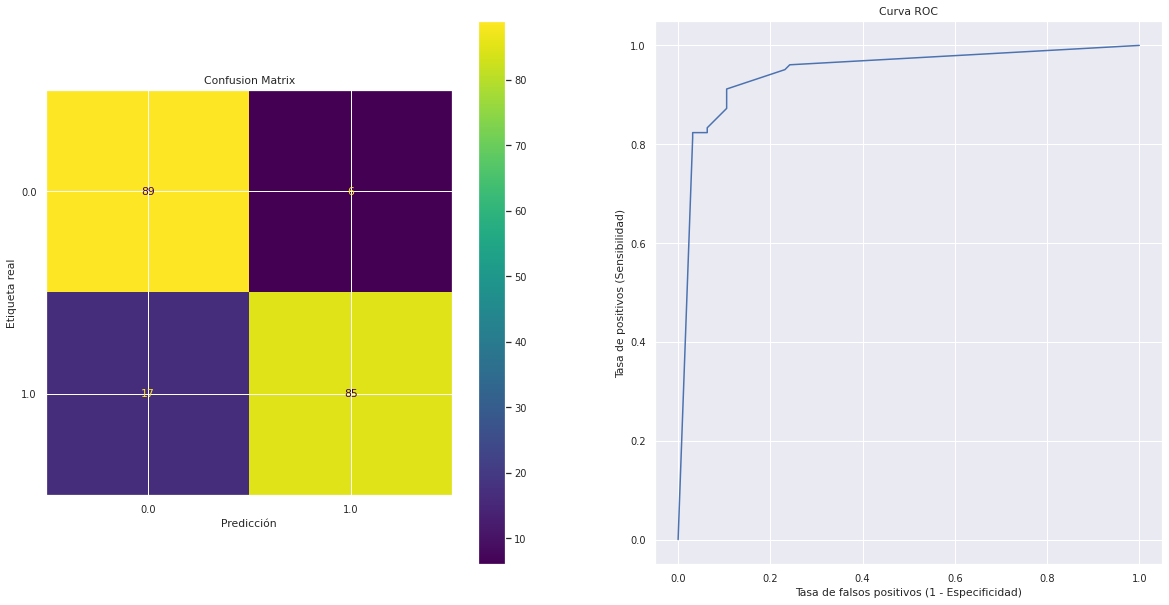

AUC: 0.9455108359133128
Accuracy: 0.883248730964467
Precision: 0.9340659340659341
Recall: 0.8333333333333334
f1-score:  0.8808290155440415


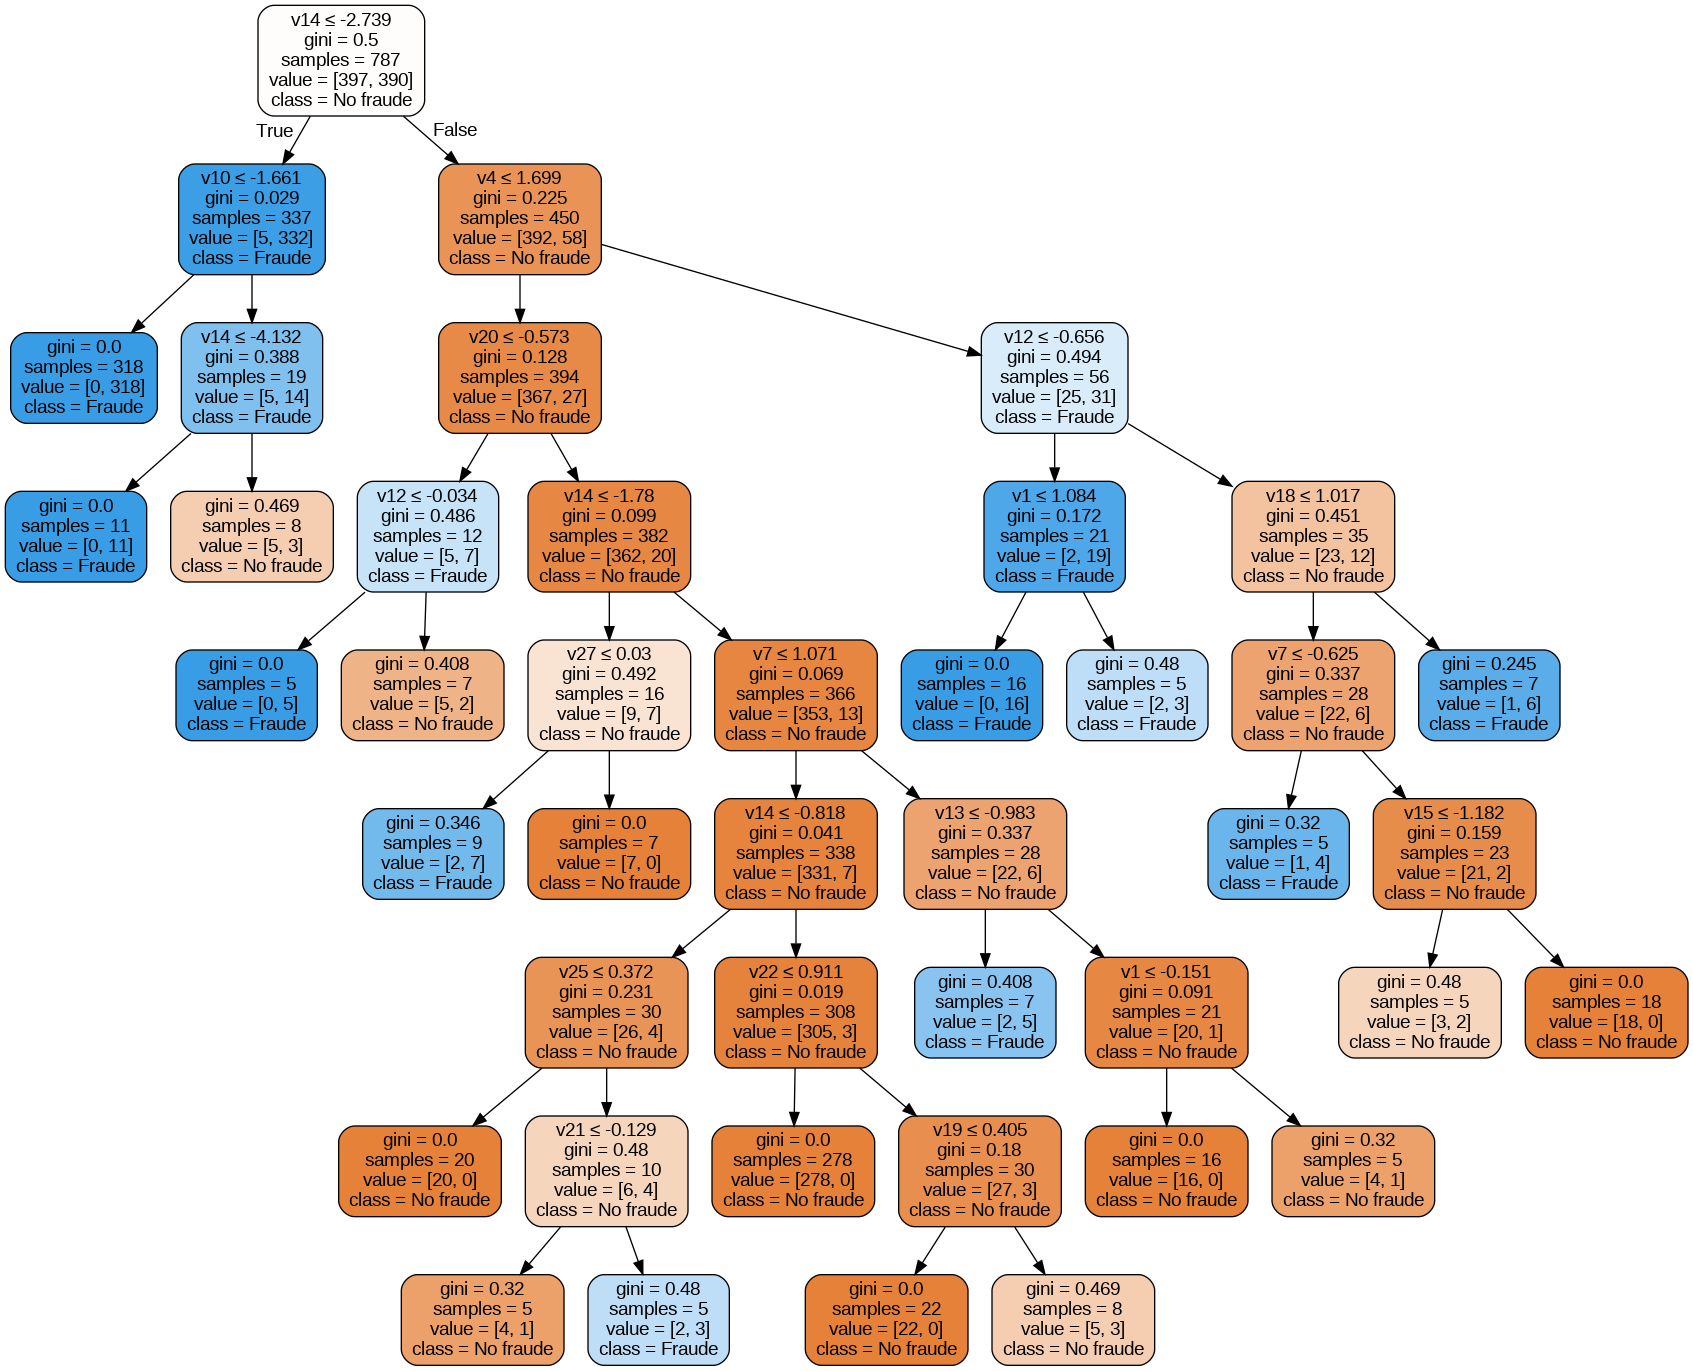

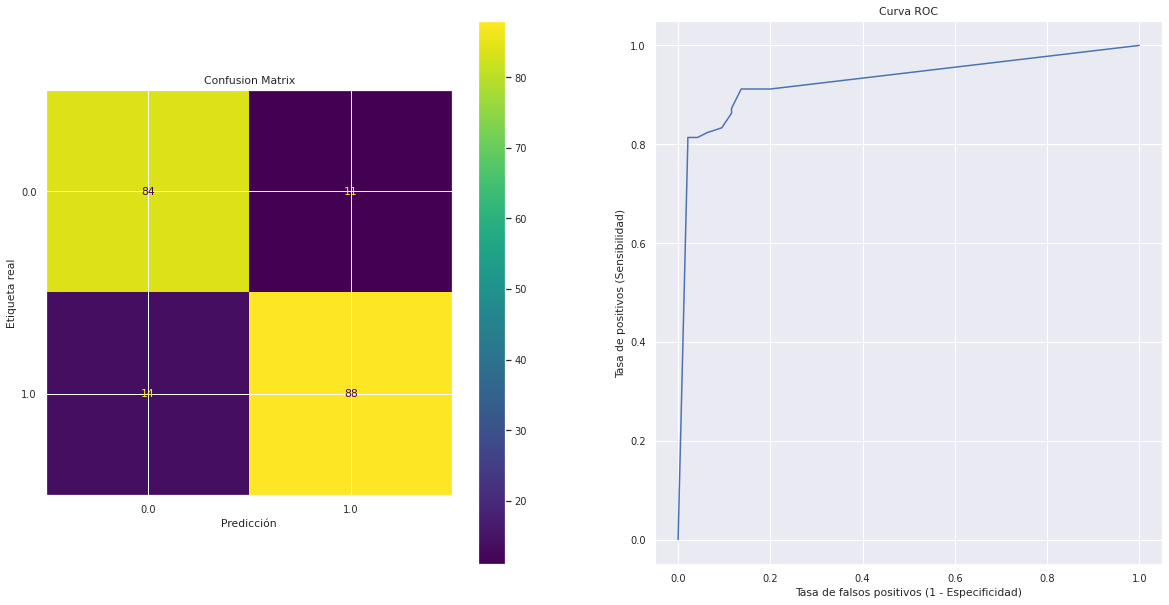

AUC: 0.9279153766769865
Accuracy: 0.8730964467005076
Precision: 0.8888888888888888
Recall: 0.8627450980392157
f1-score:  0.8756218905472637


In [31]:
tree_parameters = [
    { "criterion": "gini", "max_depth": 100, "min_samples_leaf":5 },    
    { "criterion": "entropy", "max_depth": 100, "min_samples_leaf":5 },
    { "criterion": "entropy", "max_depth": 3, "min_samples_leaf":5 },
    { "criterion": "gini", "max_depth": 3, "min_samples_leaf":5 },
    { "criterion": "gini", "max_depth": 50, "min_samples_leaf":5 },    
    { "criterion": "entropy", "max_depth": 50, "min_samples_leaf":5 },
    { "criterion": "entropy", "max_depth": 10, "min_samples_leaf":5 },
    { "criterion": "gini", "max_depth": 10, "min_samples_leaf":5 }
]

for t in tree_parameters:
    model = DecisionTreeClassifier(
        criterion = t["criterion"], random_state = 100,
        max_depth=t["max_depth"], 
        min_samples_leaf= t["min_samples_leaf"] )
    model = model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    
    model_name = "dt_%s_md_%d_msl_%d" % (t["criterion"], t["max_depth"], t["min_samples_leaf"] )
    model_description = "DT. Crit: %s. Prof Máx: %d. Min samples. %d"  % (
        t["criterion"], t["max_depth"], t["min_samples_leaf"] )
    display(HTML("<h4>"+model_description+"</h4>"))
    plot_and_save_tree_diagrams(model, model_name)
    
    model_metrics_list[model_name] = model_evaluation_report(model,y_test,y_pred,y_pred_prob,model_description)
    save_model(model,model_name+".pkl")

#### 4.2 Random Forest

Si bien las métricas obtenidas anteriormente son satisfactorias, uno de los inconvenientes que pueden tener los árboles de decisión es que memoricen las soluciones en lugar de generalizar el aprendizaje. Para mejorar este aspecto, se intentará mejorar el resultado anterior utilizando Random Forest, que hace uso de la técnica de bagging utilizando múltiples árboles como votadores del resultado final.

In [32]:
from sklearn.ensemble import RandomForestClassifier

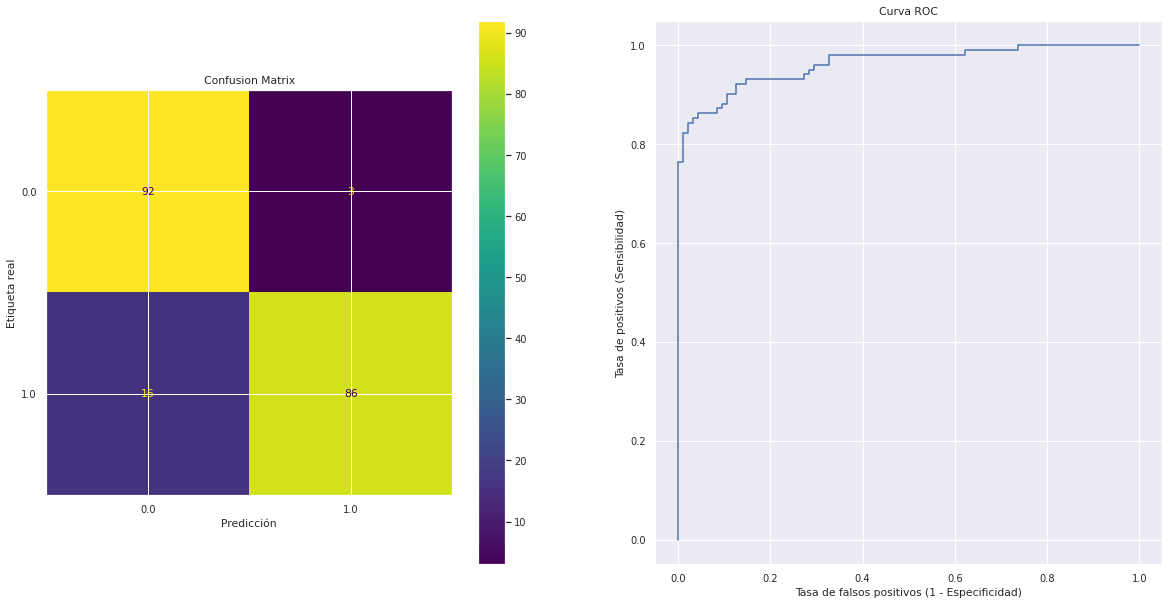

AUC: 0.9624355005159958
Accuracy: 0.9035532994923858
Precision: 0.9662921348314607
Recall: 0.8431372549019608
f1-score:  0.900523560209424


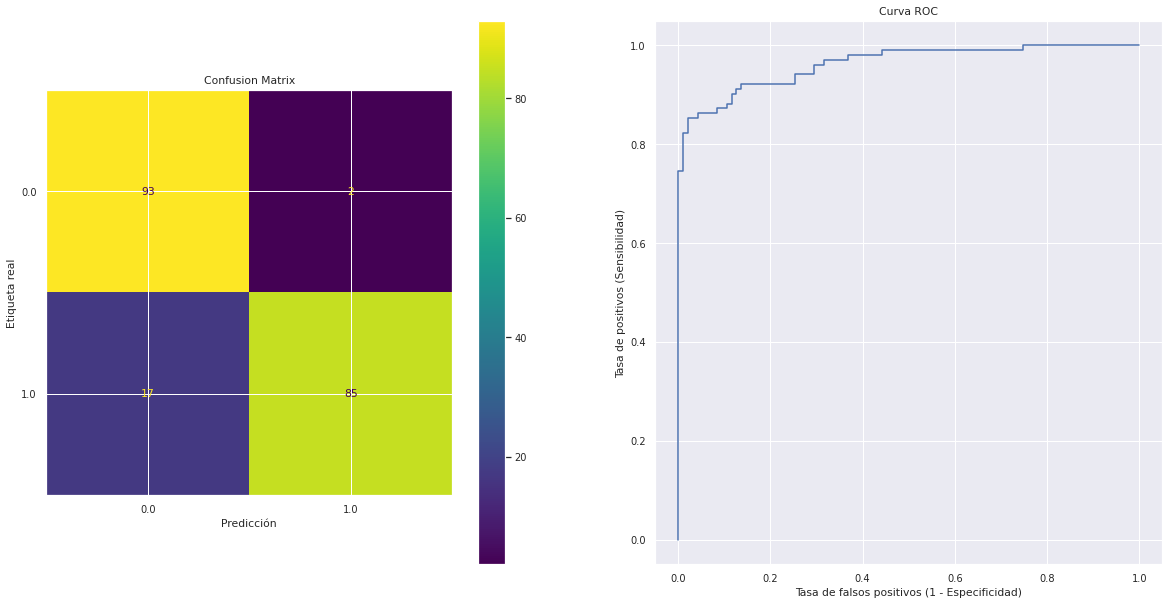

AUC: 0.9623323013415893
Accuracy: 0.9035532994923858
Precision: 0.9770114942528736
Recall: 0.8333333333333334
f1-score:  0.8994708994708996


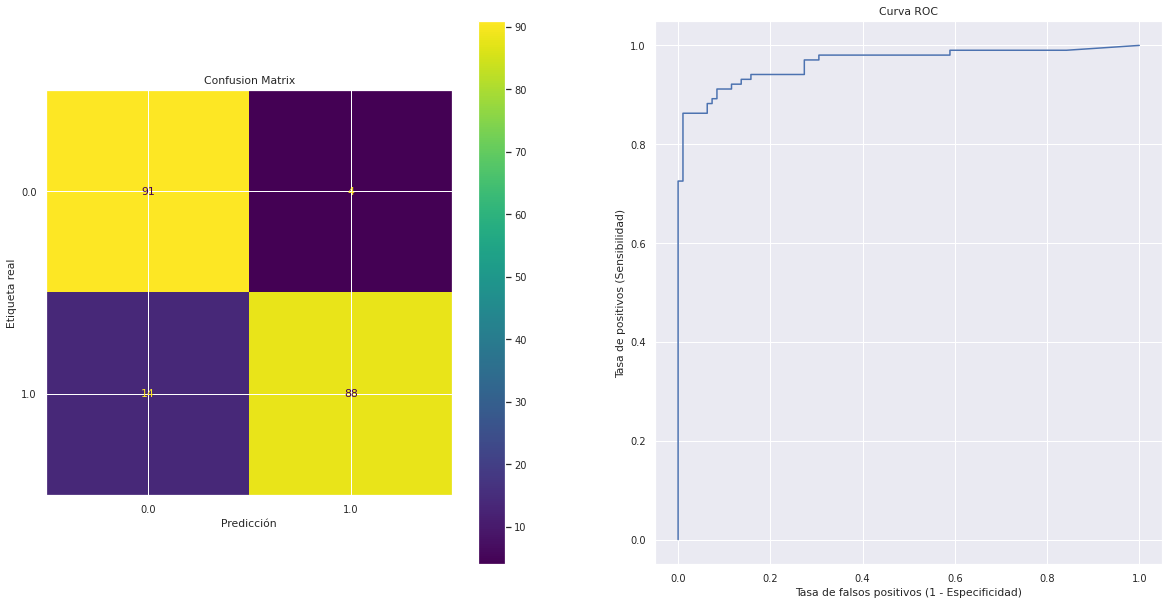

AUC: 0.9650670794633643
Accuracy: 0.9086294416243654
Precision: 0.9565217391304348
Recall: 0.8627450980392157
f1-score:  0.9072164948453608


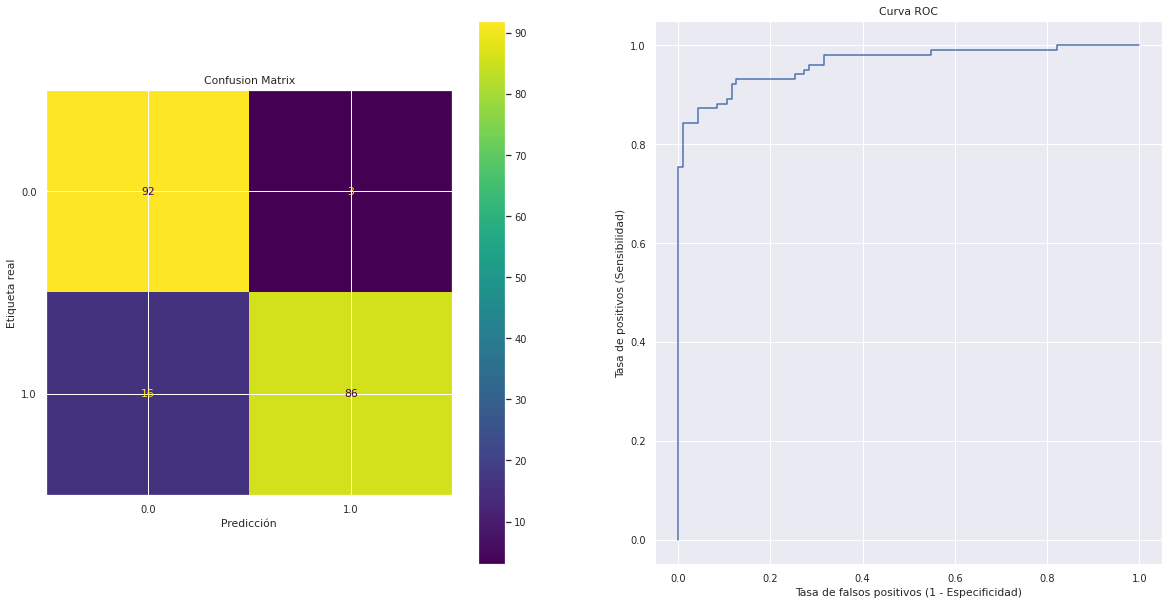

AUC: 0.9637770897832817
Accuracy: 0.9035532994923858
Precision: 0.9662921348314607
Recall: 0.8431372549019608
f1-score:  0.900523560209424


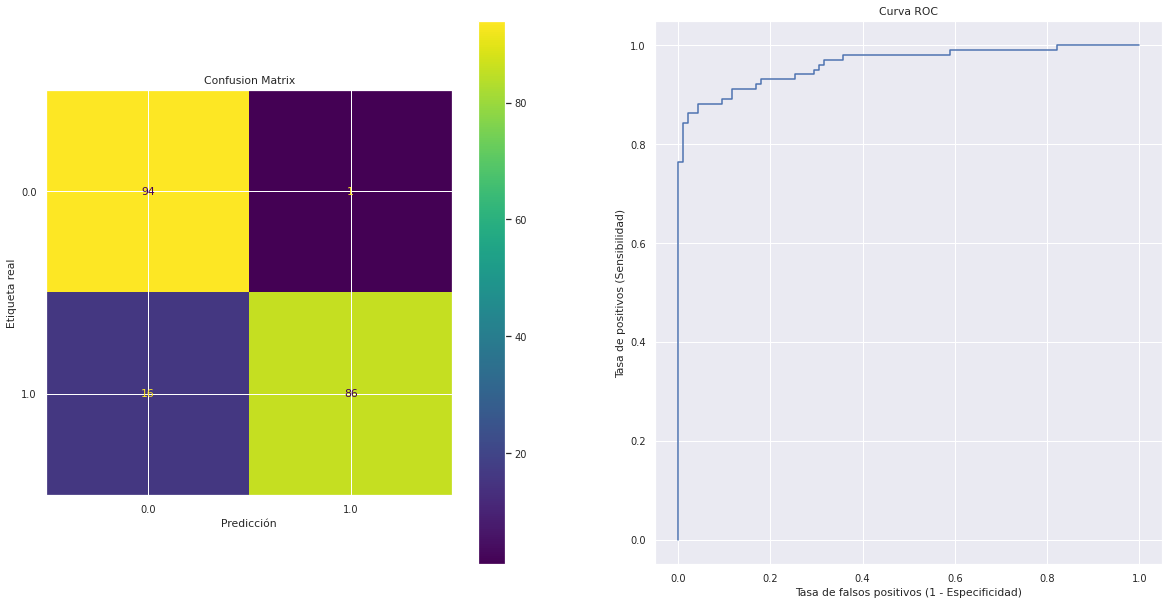

AUC: 0.9625386996904025
Accuracy: 0.9137055837563451
Precision: 0.9885057471264368
Recall: 0.8431372549019608
f1-score:  0.91005291005291


In [33]:
rf_parameters = [
    { "n_estimators": 100, "min_samples_split": 2, "min_samples_leaf":4 }, 
    { "n_estimators":  50, "min_samples_split": 10, "min_samples_leaf":4 }, 
    { "n_estimators":  30, "min_samples_split": 5, "min_samples_leaf":3 }, 
    { "n_estimators": 200, "min_samples_split": 2, "min_samples_leaf":4 }, 
    { "n_estimators": 200, "min_samples_split": 4, "min_samples_leaf":8 }
]

for rf in rf_parameters:
    model=RandomForestClassifier( n_estimators = rf["n_estimators"], 
        random_state = 100, min_samples_split=rf["min_samples_split"], 
        min_samples_leaf= rf["min_samples_leaf"] )
    model = model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    
    model_name = "rf_nest_%d_mss_%d_msl_%d" % (rf["n_estimators"], rf["min_samples_split"], rf["min_samples_leaf"] )
    model_description = "RF. N_est: %d. Part. samples: %d. Min samples. %d"  % (
        rf["n_estimators"], rf["min_samples_split"], rf["min_samples_leaf"] )
    display(HTML("<h4>"+model_description+"</h4>"))
    #plot_and_save_tree_diagrams(model, model_name)
    
    model_metrics_list[model_name] = model_evaluation_report(model,y_test,y_pred,y_pred_prob,model_description)
    save_model(model,model_name+".pkl")

#### 4.4 Regresión Logística

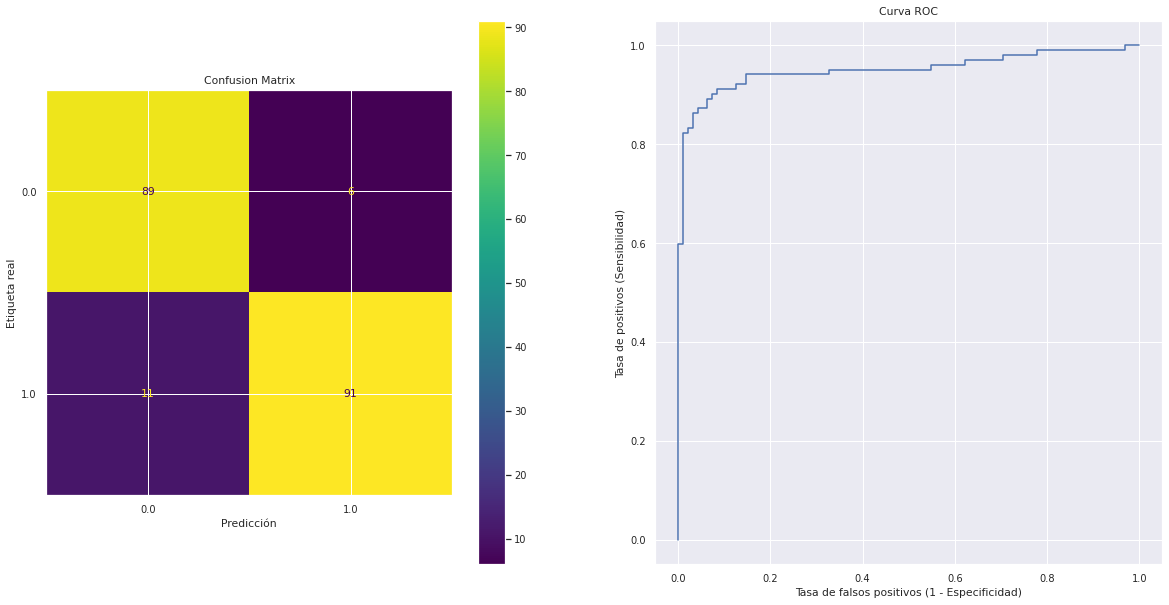

AUC: 0.9504643962848297
Accuracy: 0.9137055837563451
Precision: 0.9381443298969072
Recall: 0.8921568627450981
f1-score:  0.914572864321608


In [34]:
model = LogisticRegression(C=1, solver="sag", max_iter=5000)
model = model.fit(X_train,y_train)
y_pred=model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

model_name="lr"
model_description="Regresión Logística"
model_metrics_list[model_name] = model_evaluation_report(model,y_test,y_pred,y_pred_prob,model_description)
save_model(model,model_name+".pkl")

#### 3.5 SVM

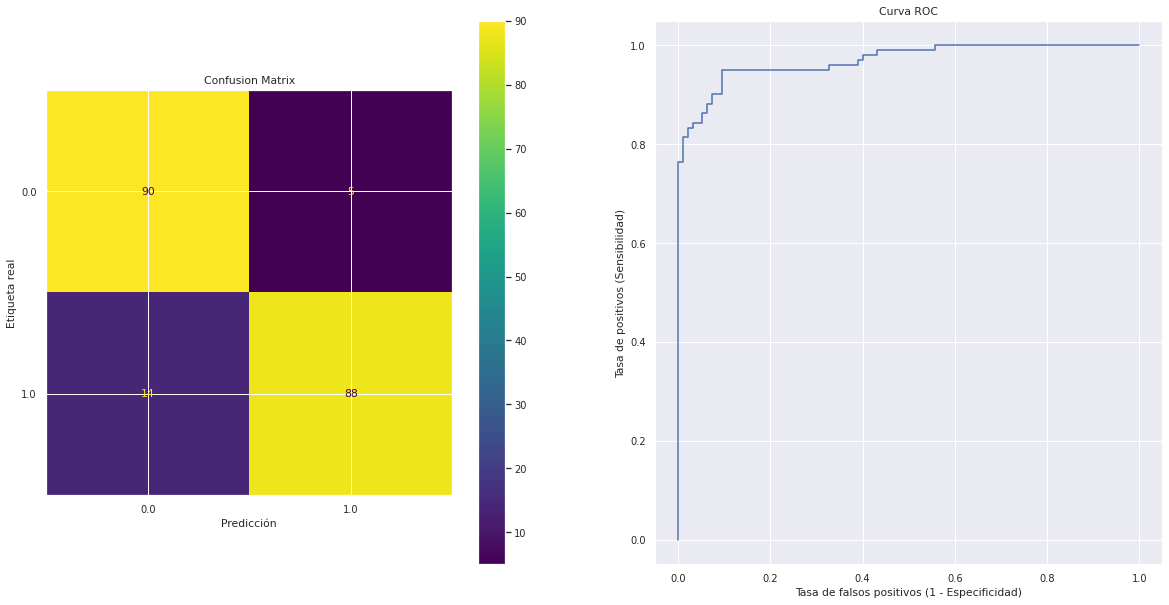

AUC: 0.9697626418988647
Accuracy: 0.9035532994923858
Precision: 0.946236559139785
Recall: 0.8627450980392157
f1-score:  0.9025641025641027


In [35]:
from sklearn import svm

model = svm.SVC(kernel='linear',probability=True) # Linear Kernel
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

model_name="svm1"
model_description = "Support Vector Machine (kernel lineal)"
model_metrics_list[model_name] = model_evaluation_report(model,y_test,y_pred,y_pred_prob,model_description)
save_model(model,model_name+".pkl")

#### 3.6 Multi Layer Perceptron

A continuación se ensayarán variantes de redes neuronales utilizando siempre Stochastic Gradient Descent, pero variando el paso de aprendizaje y la arquitectura.

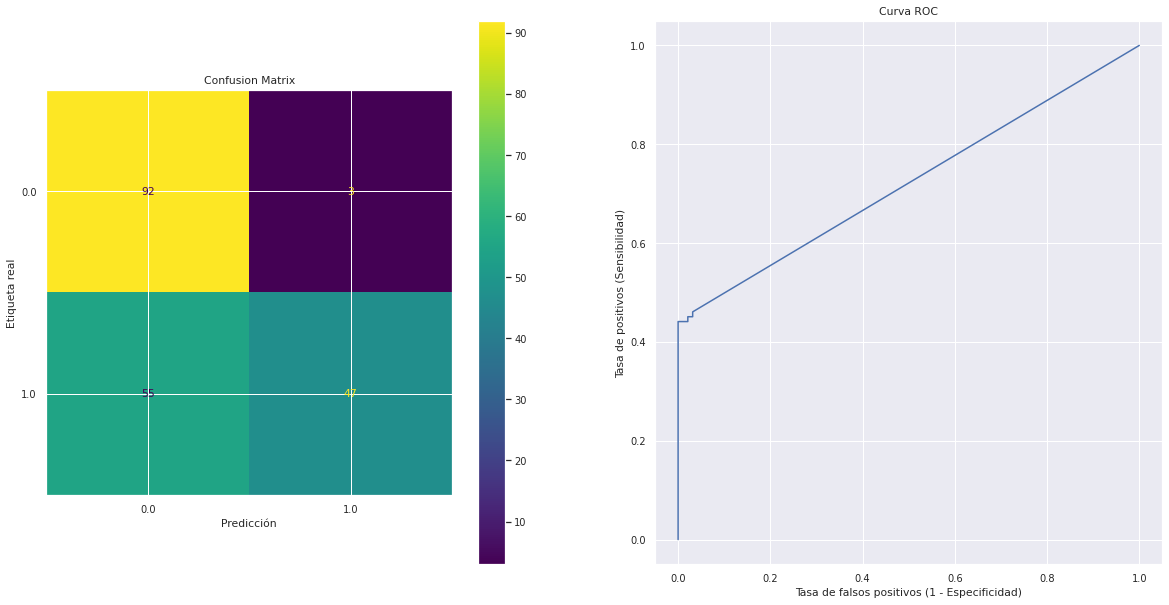

AUC: 0.7213622291021672
Accuracy: 0.7055837563451777
Precision: 0.94
Recall: 0.46078431372549017
f1-score:  0.618421052631579


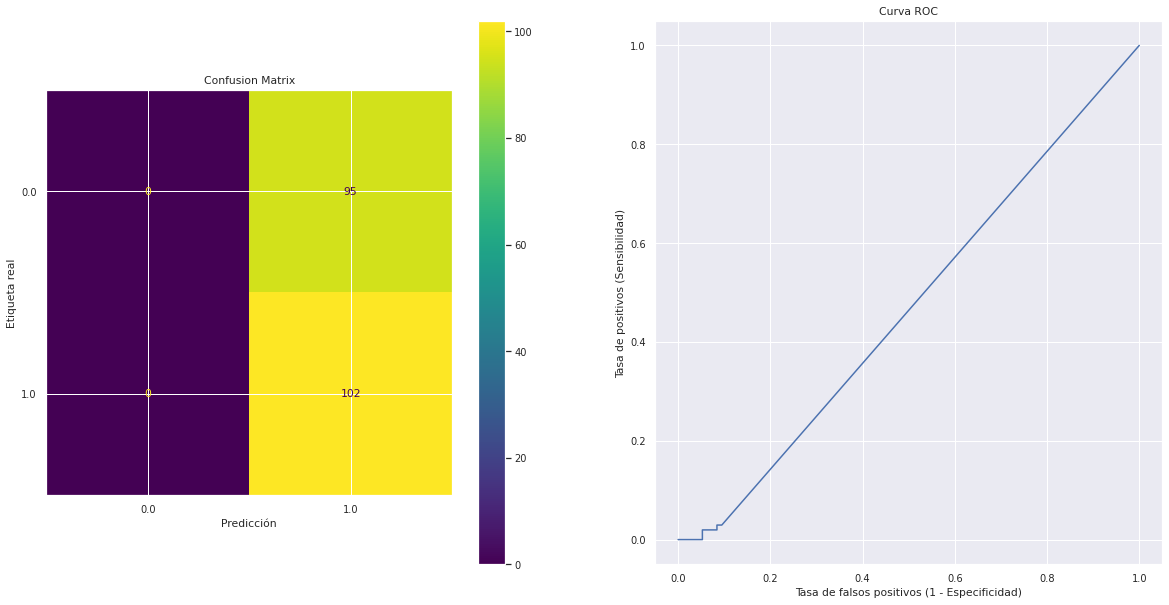

AUC: 0.46687306501547987
Accuracy: 0.5177664974619289
Precision: 0.5177664974619289
Recall: 1.0
f1-score:  0.6822742474916388


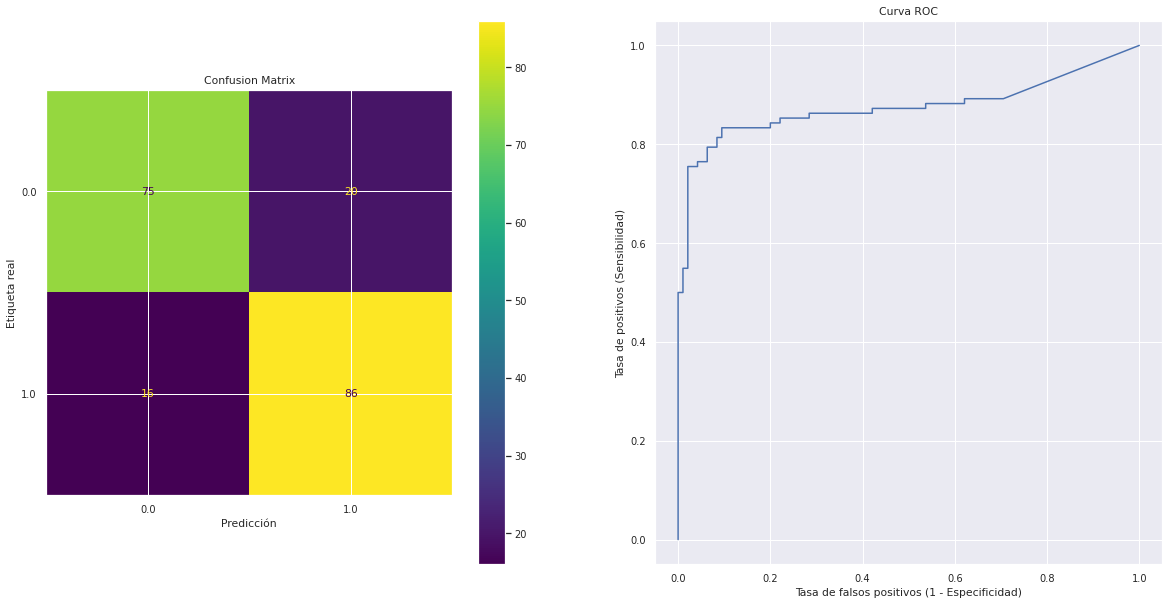

AUC: 0.8750257997936016
Accuracy: 0.817258883248731
Precision: 0.8113207547169812
Recall: 0.8431372549019608
f1-score:  0.826923076923077


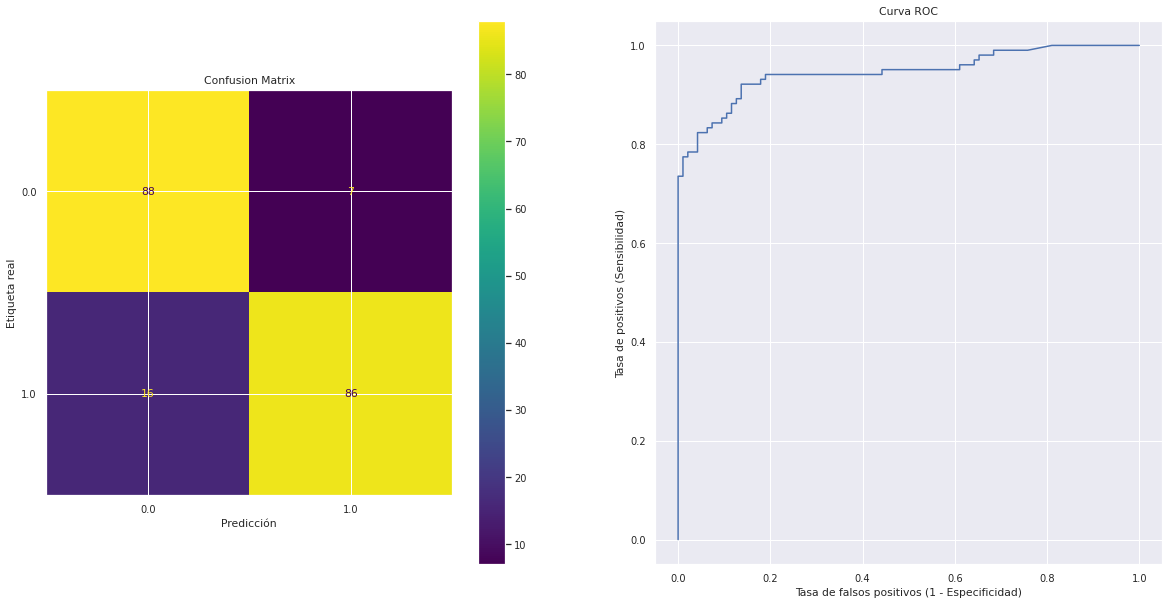

AUC: 0.9458720330237359
Accuracy: 0.883248730964467
Precision: 0.9247311827956989
Recall: 0.8431372549019608
f1-score:  0.882051282051282


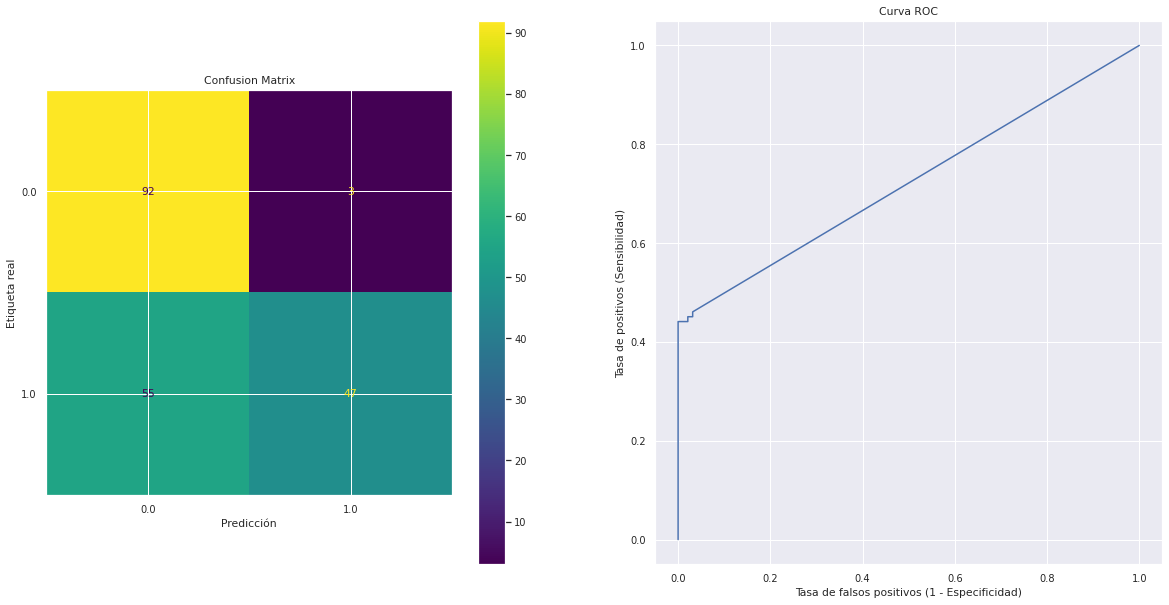

AUC: 0.7213622291021672
Accuracy: 0.7055837563451777
Precision: 0.94
Recall: 0.46078431372549017
f1-score:  0.618421052631579


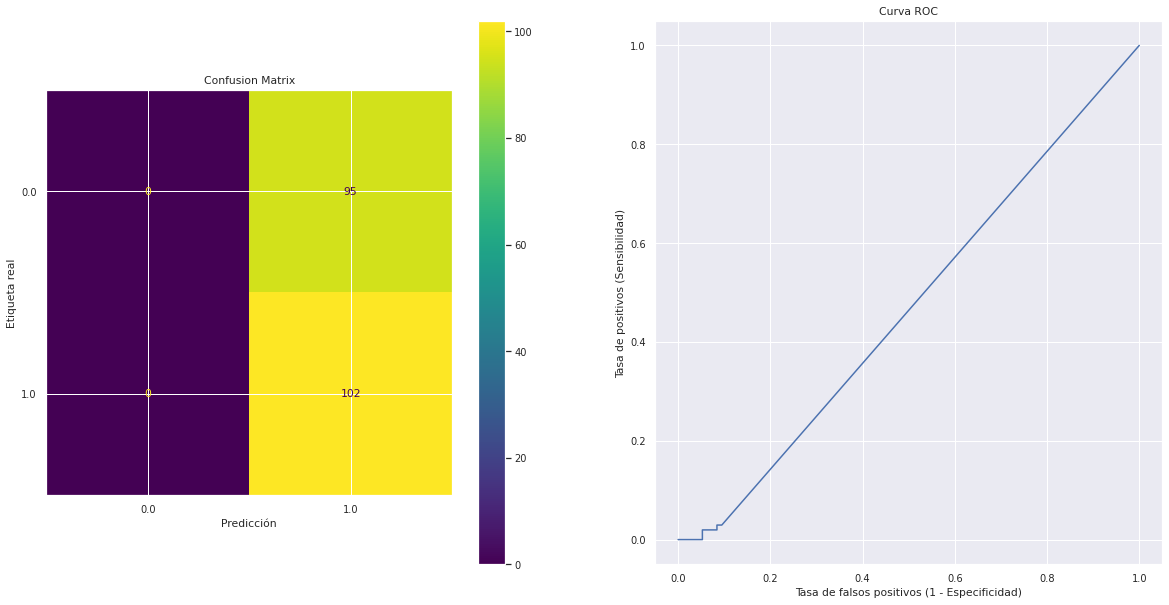

AUC: 0.46687306501547987
Accuracy: 0.5177664974619289
Precision: 0.5177664974619289
Recall: 1.0
f1-score:  0.6822742474916388


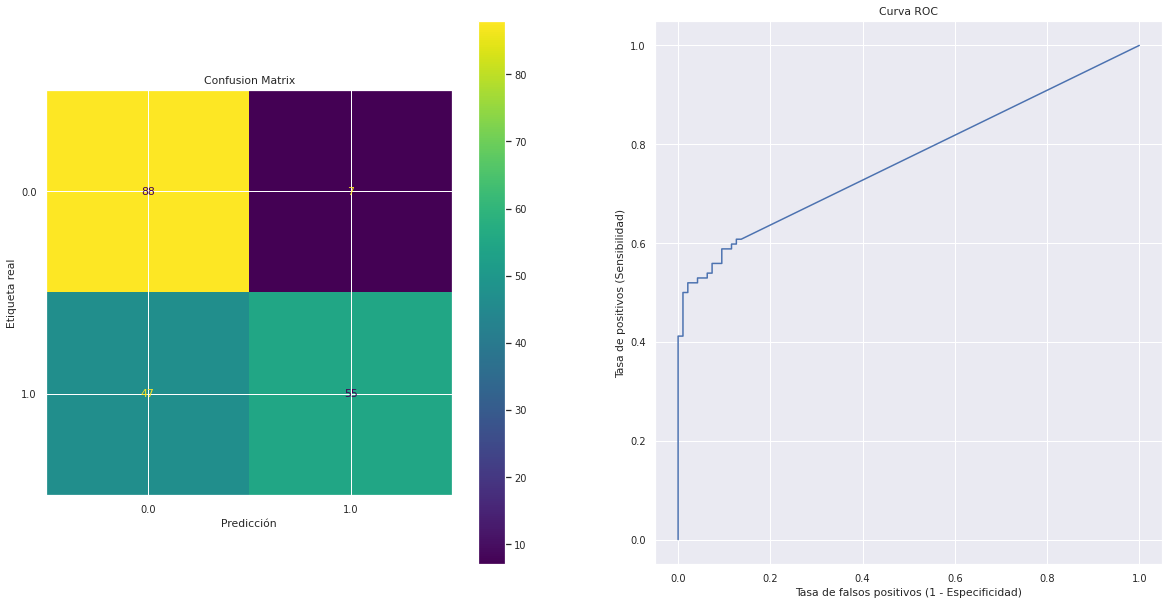

AUC: 0.7681114551083591
Accuracy: 0.7258883248730964
Precision: 0.8870967741935484
Recall: 0.5392156862745098
f1-score:  0.6707317073170732


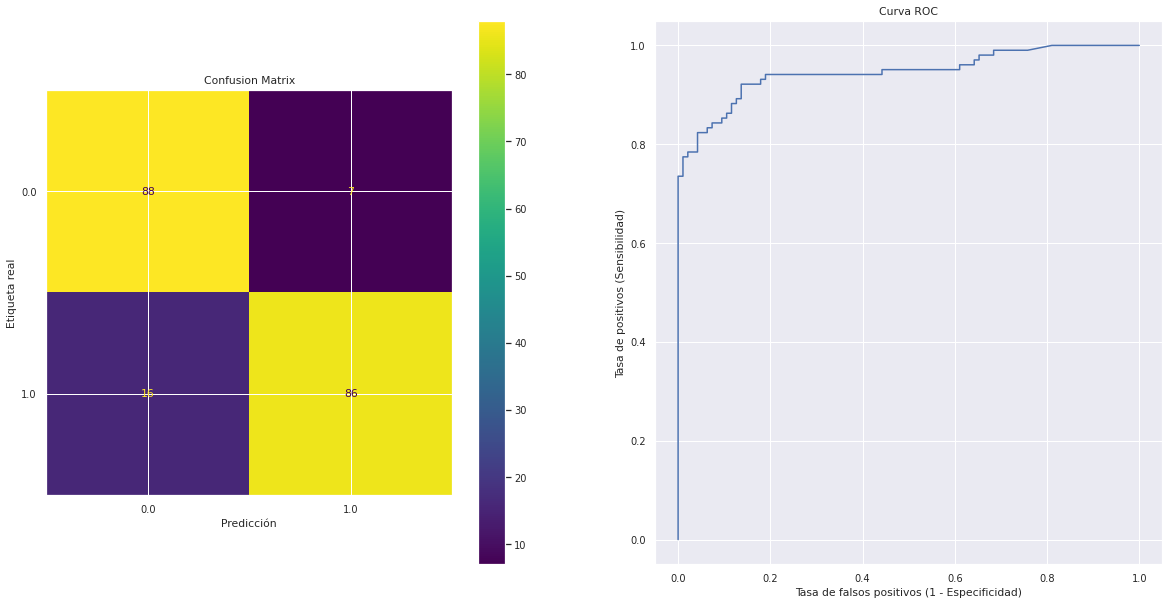

AUC: 0.9458720330237359
Accuracy: 0.883248730964467
Precision: 0.9247311827956989
Recall: 0.8431372549019608
f1-score:  0.882051282051282


In [36]:
from sklearn.neural_network import MLPClassifier

mlp_parameters = [
    { "solver": "sgd", "lr": 1e-5, "hidden_layer_sizes": (4, 2) },    
    { "solver": "sgd", "lr": 1e-5, "hidden_layer_sizes": (8, 4,2) },    
    { "solver": "sgd", "lr": 1e-5, "hidden_layer_sizes": (16, 8,4) },    
    { "solver": "sgd", "lr": 1e-5, "hidden_layer_sizes": (32,16,8,4,2) },    
    { "solver": "sgd", "lr": 1e-3, "hidden_layer_sizes": (4, 2) },    
    { "solver": "sgd", "lr": 1e-3, "hidden_layer_sizes": (8, 4,2) },    
    { "solver": "sgd", "lr": 1e-3, "hidden_layer_sizes": (16, 8,4) },    
    { "solver": "sgd", "lr": 1e-3, "hidden_layer_sizes": (32,16,8,4,2) },   
]


for mlp in mlp_parameters:
    
    model = MLPClassifier( solver=mlp['solver'], alpha=mlp['lr'], 
                          hidden_layer_sizes=mlp['hidden_layer_sizes'], random_state=1,max_iter=2000)
    model = model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    
    model_arq = "-".join("%d" % x for x in mlp['hidden_layer_sizes'])
    
    model_name = "mlp_solver_%s_lr_%f_arq_%s" % ( mlp['solver'], mlp['lr'], 
        "-".join("%d" % x for x in mlp['hidden_layer_sizes'])
    )
    model_description = "MLP. Solver: %s. Lr:%f Arq:%s" % ( mlp['solver'], mlp['lr'], 
        "-".join("%d" % x for x in mlp['hidden_layer_sizes'])
    )
    display(HTML("<h4>"+model_description+"</h4>"))
    #plot_and_save_tree_diagrams(model, model_name)
    
    model_metrics_list[model_name] = model_evaluation_report(model,y_test,y_pred,y_pred_prob,model_description)
    save_model(model,model_name+".pkl")

#### 3.7 XGBoost

Se entrenará un modelo con XGBoost utilizando los parámetros por defecto de la librería.

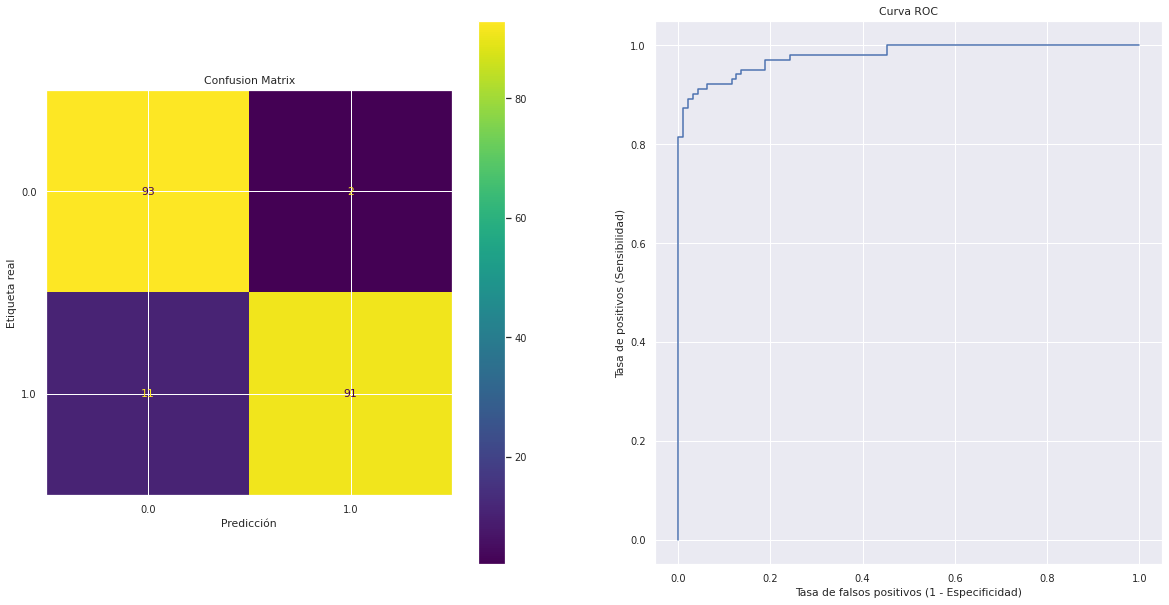

AUC: 0.9789473684210526
Accuracy: 0.934010152284264
Precision: 0.978494623655914
Recall: 0.8921568627450981
f1-score:  0.9333333333333333


In [37]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

model_name="xgboost"
model_description="XGBoost"
model_metrics_list[model_name] = model_evaluation_report(model,y_test,y_pred,y_pred_prob,model_description)
save_model(model,model_name+".pkl")

#### 3.8 K-Means (No supervisado)

Por último, se probará el desempeño de una aproximación no supervisada, K-Means, pero esta vez aplicado sobre el dataset sin comprimir con PCA.

In [38]:
model = KMeans(n_clusters=2, random_state=100).fit(X_train)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred,zero_division=False)
recall = metrics.recall_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

model_name="kmeans"
model_description="K-Means"
model_metrics_list[model_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "auc": None,
        "f1-score": f1_score,
        "description": model_description
    }
save_model(model,model_name+".pkl")

print("Accuracy:", accuracy )
print("Precision:", precision )
print("Recall:", recall)
print("f1-score: ", f1_score)

Accuracy: 0.5076142131979695
Precision: 0.6666666666666666
Recall: 0.09803921568627451
f1-score:  0.17094017094017092


El desempeño de K-Means para los parámetros seleccionados no parece satisfactorio, pero se considera un área a explorar.

## Comparación de resultados y conclusiones

A continuación se presentan las métricas para el Test Set de los modelos entrenados.

In [39]:
df = pd.DataFrame.from_dict(model_metrics_list,orient='index')
df

accuracy  precision    recall  \
base                                        0.482234   0.000000  0.000000   
dt_gini_md_100_msl_5                        0.873096   0.888889  0.862745   
dt_entropy_md_100_msl_5                     0.883249   0.934066  0.833333   
dt_entropy_md_3_msl_5                       0.888325   0.976190  0.803922   
dt_gini_md_3_msl_5                          0.873096   0.923077  0.823529   
dt_gini_md_50_msl_5                         0.873096   0.888889  0.862745   
dt_entropy_md_50_msl_5                      0.883249   0.934066  0.833333   
dt_entropy_md_10_msl_5                      0.883249   0.934066  0.833333   
dt_gini_md_10_msl_5                         0.873096   0.888889  0.862745   
rf_nest_100_mss_2_msl_4                     0.903553   0.966292  0.843137   
rf_nest_50_mss_10_msl_4                     0.903553   0.977011  0.833333   
rf_nest_30_mss_5_msl_3                      0.908629   0.956522  0.862745   
rf_nest_200_mss_2_msl_4                     0.903553   0.966292  0.843137   
rf_nest_200_mss_4_msl_8                     0.913706   0.988506  0.843137   
lr                                          0.913706   0.938144  0.892157   
svm1                                        0.903553   0.946237  0.862745   
mlp_solver_sgd_lr_0.000010_arq_4-2          0.705584   0.940000  0.460784   
mlp_solver_sgd_lr_0.000010_arq_8-4-2        0.517766   0.517766  1.000000   
mlp_solver_sgd_lr_0.000010_arq_16-8-4       0.817259   0.811321  0.843137   
mlp_solver_sgd_lr_0.000010_arq_32-16-8-4-2  0.883249   0.924731  0.843137   
mlp_solver_sgd_lr_0.001000_arq_4-2          0.705584   0.940000  0.460784   
mlp_solver_sgd_lr_0.001000_arq_8-4-2        0.517766   0.517766  1.000000   
mlp_solver_sgd_lr_0.001000_arq_16-8-4       0.725888   0.887097  0.539216   
mlp_solver_sgd_lr_0.001000_arq_32-16-8-4-2  0.883249   0.924731  0.843137   
xgboost                                     0.934010   0.978495  0.892157   
kmeans                                      0.507614   0.666667  0.098039   

                                                 auc  f1-score  \
base                                        0.500000  0.000000   
dt_gini_md_100_msl_5                        0.927915  0.875622   
dt_entropy_md_100_msl_5                     0.945511  0.880829   
dt_entropy_md_3_msl_5                       0.949432  0.881720   
dt_gini_md_3_msl_5                          0.928380  0.870466   
dt_gini_md_50_msl_5                         0.927915  0.875622   
dt_entropy_md_50_msl_5                      0.945511  0.880829   
dt_entropy_md_10_msl_5                      0.945511  0.880829   
dt_gini_md_10_msl_5                         0.927915  0.875622   
rf_nest_100_mss_2_msl_4                     0.962436  0.900524   
rf_nest_50_mss_10_msl_4                     0.962332  0.899471   
rf_nest_30_mss_5_msl_3                      0.965067  0.907216   
rf_nest_200_mss_2_msl_4                     0.963777  0.900524   
rf_nest_200_mss_4_msl_8                     0.962539  0.910053   
lr                                          0.950464  0.914573   
svm1                                        0.969763  0.902564   
mlp_solver_sgd_lr_0.000010_arq_4-2          0.721362  0.618421   
mlp_solver_sgd_lr_0.000010_arq_8-4-2        0.466873  0.682274   
mlp_solver_sgd_lr_0.000010_arq_16-8-4       0.875026  0.826923   
mlp_solver_sgd_lr_0.000010_arq_32-16-8-4-2  0.945872  0.882051   
mlp_solver_sgd_lr_0.001000_arq_4-2          0.721362  0.618421   
mlp_solver_sgd_lr_0.001000_arq_8-4-2        0.466873  0.682274   
mlp_solver_sgd_lr_0.001000_arq_16-8-4       0.768111  0.670732   
mlp_solver_sgd_lr_0.001000_arq_32-16-8-4-2  0.945872  0.882051   
xgboost                                     0.978947  0.933333   
kmeans                                           NaN  0.170940   

                                                                                 description  
base                                                                             Model

En términos generales, se podría afirmar que los mejores modelos son XGBoost, SVM y algunos casos particulares de Random Forest:

In [40]:
df.sort_values(by="auc", ascending=False).head(5)

accuracy  precision    recall       auc  f1-score  \
xgboost                  0.934010   0.978495  0.892157  0.978947  0.933333   
svm1                     0.903553   0.946237  0.862745  0.969763  0.902564   
rf_nest_30_mss_5_msl_3   0.908629   0.956522  0.862745  0.965067  0.907216   
rf_nest_200_mss_2_msl_4  0.903553   0.966292  0.843137  0.963777  0.900524   
rf_nest_200_mss_4_msl_8  0.913706   0.988506  0.843137  0.962539  0.910053   

                                                              description  
xgboost                                                           XGBoost  
svm1                               Support Vector Machine (kernel lineal)  
rf_nest_30_mss_5_msl_3    RF. N_est: 30. Part. samples: 5. Min samples. 3  
rf_nest_200_mss_2_msl_4  RF. N_est: 200. Part. samples: 2. Min samples. 4  
rf_nest_200_mss_4_msl_8  RF. N_est: 200. Part. samples: 4. Min samples. 8

Ahora bien, teniendo presente que en este caso detectar un falso positivo no es tan grave porque sólo indica que una actividad es sospechosa y requiere ser investigada (y esto siempre y cuando la tasa de falsos positivos esté por debajo de un umbral aceptable) una métrica de interés puede ser el accuracy. En este caso, los mejores candidatos son XGBoost, regresión Logística y algunos casos de Random Forest.

In [41]:
df.sort_values(by="accuracy", ascending=False).head(5)

accuracy  precision    recall       auc  f1-score  \
xgboost                  0.934010   0.978495  0.892157  0.978947  0.933333   
rf_nest_200_mss_4_msl_8  0.913706   0.988506  0.843137  0.962539  0.910053   
lr                       0.913706   0.938144  0.892157  0.950464  0.914573   
rf_nest_30_mss_5_msl_3   0.908629   0.956522  0.862745  0.965067  0.907216   
rf_nest_100_mss_2_msl_4  0.903553   0.966292  0.843137  0.962436  0.900524   

                                                              description  
xgboost                                                           XGBoost  
rf_nest_200_mss_4_msl_8  RF. N_est: 200. Part. samples: 4. Min samples. 8  
lr                                                    Regresión Logística  
rf_nest_30_mss_5_msl_3    RF. N_est: 30. Part. samples: 5. Min samples. 3  
rf_nest_100_mss_2_msl_4  RF. N_est: 100. Part. samples: 2. Min samples. 4

En caso de tener que optar por un modelo para predicción, se recomendaría el uso del modelo 'xgboost'.

### Trabajo futuro

- Mejorar mecanismo de selección de modelos con Grid Search u otro algoritmo.
- Profundizar estudio de comportamiento de algoritmos, ensayar más juegos de parámetros para algoritmos SVM y XGBoost.
- Evaluar otras estrategias para algoritmos no supervisados.
- Incorporar información temporal.

## Bibliografía y referencias

- Ejercicio integrador de Clase 7 de materia Deep Learning 1. 
- Notebooks vistos en las clases de Machine Learning 1.
- Notebooks de ejemplo de Kaggle para dataset elegido y otros casos similares de detección de fraude y anomalías. https://www.kaggle.com/mlg-ulb/creditcardfraud/notebooks.
- "The Elements of Statistical Learning". Trevor Hastie. Springer
- "An Introduction to Statistical Learning". Gareth James. Springer
